In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from IPython.core.display import Image, display
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline
from collections import Counter

from sklearn.metrics import classification_report

from keras import models, layers, optimizers
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical 
from tqdm import tqdm
import math
import pickle
import os
from PIL import ImageFile
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
# from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    """Returns the path and the Label from the folder"""
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../imgs/images/train')
val_files, val_targets =  load_dataset('../imgs/images/val')
test_files, test_targets = load_dataset('../imgs/images/test')

# load list of dog names
labels = [item[21:-1] for item in sorted(glob("../imgs/images/train/*/"))]
CLASSES = len(labels)

#proportions
train_prop = np.count_nonzero(train_targets, axis=0) / len(train_targets)
val_prop = np.count_nonzero(val_targets, axis=0) / len(val_targets)
test_prop = np.count_nonzero(test_targets, axis=0) / len(test_targets)

print('Proportions: \n')
for index, label in enumerate(labels):
    print('{} train: {:.4f}%'.format(label, train_prop[index]*100))
    print('{} val: {:.4f}%'.format(label, val_prop[index]*100))
    print('{} test: {:.4f}%'.format(label, test_prop[index]*100))
    print('*********************')

print('\nStatistics about the Dataset:\n')
print('There are %d total chest deseases.' % len(labels))
print('There are %s total chest images.\n' % len(np.hstack([train_files,val_files, test_files])))
print('There are %d training chest images.' % len(train_files))
print('There are %d val chest images.'% len(val_files))
print('There are %d test chest images.'% len(test_files))

Proportions: 

Infiltration train: 50.0000%
Infiltration val: 50.0000%
Infiltration test: 50.0000%
*********************
No Finding train: 50.0000%
No Finding val: 50.0000%
No Finding test: 50.0000%
*********************

Statistics about the Dataset:

There are 2 total chest deseases.
There are 19094 total chest images.

There are 14654 training chest images.
There are 2220 val chest images.
There are 2220 test chest images.


In [3]:
train_DENSNET = np.load('bottleneck_features_train.npy')
val_DENSNET = np.load('bottleneck_features_val.npy')
test_DENSNET = np.load('bottleneck_features_test.npy')

In [4]:
# dimensions of our images.  
IMG_WIDTH, IMG_HEIGHT = 224, 224 

# number of epochs to train top model  
EPOCHS = 2  
# batch size used by flow_from_directory and predict_generator  
BATCH_SIZE = 16

In [5]:
train_data_dir = '../imgs/images/train'
validation_data_dir = '../imgs/images/val'
test_data_dir = '../imgs/images/test'
datagen_top = ImageDataGenerator(rescale=1./255)  

# Train
generator_top_train = datagen_top.flow_from_directory(train_data_dir,  
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),  
                                                 batch_size = BATCH_SIZE,  
                                                 class_mode = 'categorical',  
                                                 shuffle = False)  

nb_train_samples = len(generator_top_train.filenames)  
num_classes = len(generator_top_train.class_indices)  

# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  

# get the class lebels for the training data, in the original order  
train_labels = generator_top_train.classes  

# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  
#------------------------------------------------------------------------------

# Validation
generator_top_val = datagen_top.flow_from_directory(validation_data_dir,  
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT),  
                                                 batch_size=BATCH_SIZE,  
                                                 class_mode=None,  
                                                 shuffle=False)  

nb_validation_samples = len(generator_top_val.filenames)  

validation_data = np.load('bottleneck_features_val.npy')  

validation_labels = generator_top_val.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)
#------------------------------------------------------------------------------

# Test
generator_top_test = datagen_top.flow_from_directory(test_data_dir,  
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT),  
                                                 batch_size=BATCH_SIZE,  
                                                 class_mode=None,  
                                                 shuffle=False)  

nb_test_samples = len(generator_top_test.filenames)  

test_data = np.load('bottleneck_features_test.npy')  

test_labels = generator_top_test.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 14654 images belonging to 2 classes.
Found 2220 images belonging to 2 classes.
Found 2220 images belonging to 2 classes.


In [6]:
validation_data.shape, validation_labels.shape, train_data.shape, train_labels.shape

((2208, 7, 7, 1024), (2220, 2), (14640, 7, 7, 1024), (14654, 2))

In [7]:
top_model_weights_path = 'bottleneck_fc_model.h5' 

model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels[:14640],  
      epochs=EPOCHS,  
      batch_size=BATCH_SIZE,  
      validation_data=(validation_data, validation_labels[:2208]))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels[:2208], batch_size=BATCH_SIZE, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))

Train on 14640 samples, validate on 2208 samples
Epoch 1/2


 3248/14640 [=====>........................] - ETA: 26:20 - loss: 0.8198 - acc: 0.50 - ETA: 15:00 - loss: 1.3878 - acc: 0.50 - ETA: 11:29 - loss: 1.1562 - acc: 0.52 - ETA: 9:25 - loss: 1.0547 - acc: 0.4688 - ETA: 8:15 - loss: 0.9763 - acc: 0.462 - ETA: 7:34 - loss: 0.9291 - acc: 0.437 - ETA: 7:01 - loss: 0.8954 - acc: 0.473 - ETA: 6:39 - loss: 0.8701 - acc: 0.484 - ETA: 6:17 - loss: 0.8504 - acc: 0.479 - ETA: 6:03 - loss: 0.8347 - acc: 0.468 - ETA: 5:48 - loss: 0.8218 - acc: 0.465 - ETA: 5:36 - loss: 0.8111 - acc: 0.479 - ETA: 5:27 - loss: 0.8020 - acc: 0.485 - ETA: 5:19 - loss: 0.7943 - acc: 0.486 - ETA: 5:13 - loss: 0.7875 - acc: 0.491 - ETA: 5:07 - loss: 0.7816 - acc: 0.488 - ETA: 5:00 - loss: 0.7764 - acc: 0.496 - ETA: 4:54 - loss: 0.7718 - acc: 0.503 - ETA: 4:49 - loss: 0.7677 - acc: 0.513 - ETA: 4:44 - loss: 0.7639 - acc: 0.512 - ETA: 4:40 - loss: 0.7606 - acc: 0.520 - ETA: 4:36 - loss: 0.7575 - acc: 0.514 - ETA: 4:32 - loss: 0.7547 - acc: 0.519 - ETA: 4:29 - loss: 0.7521 - acc: 

 6512/14640 [============>.................] - ETA: 3:03 - loss: 0.6999 - acc: 0.491 - ETA: 3:03 - loss: 0.6998 - acc: 0.490 - ETA: 3:02 - loss: 0.6998 - acc: 0.490 - ETA: 3:02 - loss: 0.6998 - acc: 0.490 - ETA: 3:02 - loss: 0.6997 - acc: 0.489 - ETA: 3:02 - loss: 0.6997 - acc: 0.490 - ETA: 3:02 - loss: 0.6997 - acc: 0.490 - ETA: 3:02 - loss: 0.6997 - acc: 0.490 - ETA: 3:01 - loss: 0.6996 - acc: 0.489 - ETA: 3:01 - loss: 0.6996 - acc: 0.489 - ETA: 3:01 - loss: 0.6996 - acc: 0.489 - ETA: 3:01 - loss: 0.6995 - acc: 0.488 - ETA: 3:01 - loss: 0.6995 - acc: 0.488 - ETA: 3:00 - loss: 0.6995 - acc: 0.488 - ETA: 3:00 - loss: 0.6994 - acc: 0.488 - ETA: 3:00 - loss: 0.6994 - acc: 0.488 - ETA: 2:59 - loss: 0.6994 - acc: 0.487 - ETA: 2:59 - loss: 0.6994 - acc: 0.487 - ETA: 2:59 - loss: 0.6993 - acc: 0.486 - ETA: 2:59 - loss: 0.6993 - acc: 0.485 - ETA: 2:58 - loss: 0.6993 - acc: 0.485 - ETA: 2:58 - loss: 0.6992 - acc: 0.485 - ETA: 2:58 - loss: 0.6992 - acc: 0.486 - ETA: 2:57 - loss: 0.6992 - acc: 0

 9776/14640 [===================>..........] - ETA: 2:10 - loss: 0.6965 - acc: 0.489 - ETA: 2:10 - loss: 0.6965 - acc: 0.489 - ETA: 2:10 - loss: 0.6965 - acc: 0.489 - ETA: 2:10 - loss: 0.6965 - acc: 0.489 - ETA: 2:09 - loss: 0.6965 - acc: 0.489 - ETA: 2:09 - loss: 0.6965 - acc: 0.490 - ETA: 2:09 - loss: 0.6965 - acc: 0.490 - ETA: 2:09 - loss: 0.6965 - acc: 0.490 - ETA: 2:08 - loss: 0.6964 - acc: 0.490 - ETA: 2:08 - loss: 0.6964 - acc: 0.490 - ETA: 2:08 - loss: 0.6964 - acc: 0.490 - ETA: 2:07 - loss: 0.6964 - acc: 0.490 - ETA: 2:07 - loss: 0.6964 - acc: 0.490 - ETA: 2:07 - loss: 0.6964 - acc: 0.490 - ETA: 2:07 - loss: 0.6964 - acc: 0.490 - ETA: 2:07 - loss: 0.6964 - acc: 0.490 - ETA: 2:06 - loss: 0.6964 - acc: 0.490 - ETA: 2:06 - loss: 0.6964 - acc: 0.490 - ETA: 2:06 - loss: 0.6964 - acc: 0.490 - ETA: 2:06 - loss: 0.6964 - acc: 0.491 - ETA: 2:05 - loss: 0.6964 - acc: 0.491 - ETA: 2:05 - loss: 0.6963 - acc: 0.491 - ETA: 2:05 - loss: 0.6963 - acc: 0.491 - ETA: 2:05 - loss: 0.6963 - acc: 0

13152/14640 [=========================>....] - ETA: 1:18 - loss: 0.6983 - acc: 0.496 - ETA: 1:18 - loss: 0.6983 - acc: 0.496 - ETA: 1:17 - loss: 0.6983 - acc: 0.495 - ETA: 1:17 - loss: 0.6983 - acc: 0.496 - ETA: 1:17 - loss: 0.6983 - acc: 0.495 - ETA: 1:17 - loss: 0.6983 - acc: 0.495 - ETA: 1:16 - loss: 0.6982 - acc: 0.496 - ETA: 1:16 - loss: 0.6982 - acc: 0.496 - ETA: 1:16 - loss: 0.6982 - acc: 0.496 - ETA: 1:16 - loss: 0.6982 - acc: 0.496 - ETA: 1:15 - loss: 0.6982 - acc: 0.496 - ETA: 1:15 - loss: 0.6982 - acc: 0.496 - ETA: 1:15 - loss: 0.6982 - acc: 0.496 - ETA: 1:15 - loss: 0.6982 - acc: 0.496 - ETA: 1:14 - loss: 0.6982 - acc: 0.496 - ETA: 1:14 - loss: 0.6982 - acc: 0.496 - ETA: 1:14 - loss: 0.6982 - acc: 0.496 - ETA: 1:14 - loss: 0.6982 - acc: 0.496 - ETA: 1:13 - loss: 0.6982 - acc: 0.496 - ETA: 1:13 - loss: 0.6981 - acc: 0.496 - ETA: 1:13 - loss: 0.6981 - acc: 0.496 - ETA: 1:13 - loss: 0.6981 - acc: 0.497 - ETA: 1:12 - loss: 0.6981 - acc: 0.496 - ETA: 1:12 - loss: 0.6981 - acc: 0

14640/14640 [==============================] - ETA: 24s - loss: 0.6981 - acc: 0.50 - ETA: 23s - loss: 0.6980 - acc: 0.50 - ETA: 23s - loss: 0.6980 - acc: 0.50 - ETA: 23s - loss: 0.6980 - acc: 0.50 - ETA: 22s - loss: 0.6980 - acc: 0.50 - ETA: 22s - loss: 0.6980 - acc: 0.50 - ETA: 22s - loss: 0.6980 - acc: 0.50 - ETA: 22s - loss: 0.6980 - acc: 0.50 - ETA: 21s - loss: 0.6980 - acc: 0.50 - ETA: 21s - loss: 0.6980 - acc: 0.50 - ETA: 21s - loss: 0.6980 - acc: 0.50 - ETA: 21s - loss: 0.6980 - acc: 0.50 - ETA: 20s - loss: 0.6980 - acc: 0.50 - ETA: 20s - loss: 0.6980 - acc: 0.50 - ETA: 20s - loss: 0.6980 - acc: 0.50 - ETA: 20s - loss: 0.6980 - acc: 0.50 - ETA: 19s - loss: 0.6980 - acc: 0.50 - ETA: 19s - loss: 0.6980 - acc: 0.50 - ETA: 19s - loss: 0.6979 - acc: 0.50 - ETA: 19s - loss: 0.6979 - acc: 0.50 - ETA: 18s - loss: 0.6979 - acc: 0.50 - ETA: 18s - loss: 0.6979 - acc: 0.50 - ETA: 18s - loss: 0.6979 - acc: 0.50 - ETA: 18s - loss: 0.6979 - acc: 0.50 - ETA: 17s - loss: 0.6979 - acc: 0.50 - ETA

 3264/14640 [=====>........................] - ETA: 3:50 - loss: 0.6931 - acc: 0.625 - ETA: 3:55 - loss: 0.6931 - acc: 0.656 - ETA: 3:57 - loss: 0.6931 - acc: 0.625 - ETA: 3:57 - loss: 0.6931 - acc: 0.578 - ETA: 4:04 - loss: 0.6931 - acc: 0.550 - ETA: 4:06 - loss: 0.6931 - acc: 0.562 - ETA: 4:03 - loss: 0.6931 - acc: 0.562 - ETA: 3:58 - loss: 0.6931 - acc: 0.554 - ETA: 4:01 - loss: 0.6931 - acc: 0.555 - ETA: 4:00 - loss: 0.6931 - acc: 0.568 - ETA: 3:56 - loss: 0.6931 - acc: 0.568 - ETA: 3:55 - loss: 0.6931 - acc: 0.562 - ETA: 3:56 - loss: 0.6931 - acc: 0.567 - ETA: 3:53 - loss: 0.6931 - acc: 0.562 - ETA: 3:52 - loss: 0.6931 - acc: 0.562 - ETA: 3:51 - loss: 0.6931 - acc: 0.570 - ETA: 3:50 - loss: 0.6931 - acc: 0.566 - ETA: 3:49 - loss: 0.6931 - acc: 0.559 - ETA: 3:47 - loss: 0.6931 - acc: 0.555 - ETA: 3:46 - loss: 0.6931 - acc: 0.543 - ETA: 3:47 - loss: 0.6931 - acc: 0.538 - ETA: 3:46 - loss: 0.6931 - acc: 0.539 - ETA: 3:45 - loss: 0.6931 - acc: 0.546 - ETA: 3:45 - loss: 0.6931 - acc: 0

 6528/14640 [============>.................] - ETA: 2:57 - loss: 0.6931 - acc: 0.506 - ETA: 2:57 - loss: 0.6931 - acc: 0.506 - ETA: 2:57 - loss: 0.6931 - acc: 0.506 - ETA: 2:57 - loss: 0.6931 - acc: 0.506 - ETA: 2:57 - loss: 0.6931 - acc: 0.506 - ETA: 2:56 - loss: 0.6931 - acc: 0.507 - ETA: 2:56 - loss: 0.6931 - acc: 0.505 - ETA: 2:56 - loss: 0.6931 - acc: 0.505 - ETA: 2:56 - loss: 0.6931 - acc: 0.505 - ETA: 2:56 - loss: 0.6931 - acc: 0.505 - ETA: 2:55 - loss: 0.6931 - acc: 0.506 - ETA: 2:55 - loss: 0.6931 - acc: 0.506 - ETA: 2:55 - loss: 0.6931 - acc: 0.506 - ETA: 2:55 - loss: 0.6931 - acc: 0.506 - ETA: 2:55 - loss: 0.6931 - acc: 0.506 - ETA: 2:54 - loss: 0.6931 - acc: 0.506 - ETA: 2:54 - loss: 0.6931 - acc: 0.506 - ETA: 2:54 - loss: 0.6931 - acc: 0.507 - ETA: 2:54 - loss: 0.6931 - acc: 0.507 - ETA: 2:54 - loss: 0.6931 - acc: 0.507 - ETA: 2:54 - loss: 0.6931 - acc: 0.507 - ETA: 2:53 - loss: 0.6931 - acc: 0.508 - ETA: 2:53 - loss: 0.6931 - acc: 0.508 - ETA: 2:53 - loss: 0.6931 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:11 - loss: 0.6931 - acc: 0.504 - ETA: 2:11 - loss: 0.6931 - acc: 0.503 - ETA: 2:11 - loss: 0.6931 - acc: 0.503 - ETA: 2:11 - loss: 0.6931 - acc: 0.504 - ETA: 2:10 - loss: 0.6931 - acc: 0.504 - ETA: 2:10 - loss: 0.6931 - acc: 0.505 - ETA: 2:10 - loss: 0.6931 - acc: 0.504 - ETA: 2:10 - loss: 0.6931 - acc: 0.504 - ETA: 2:09 - loss: 0.6931 - acc: 0.504 - ETA: 2:09 - loss: 0.6931 - acc: 0.504 - ETA: 2:09 - loss: 0.6931 - acc: 0.504 - ETA: 2:09 - loss: 0.6931 - acc: 0.504 - ETA: 2:08 - loss: 0.6931 - acc: 0.505 - ETA: 2:08 - loss: 0.6931 - acc: 0.505 - ETA: 2:08 - loss: 0.6931 - acc: 0.505 - ETA: 2:07 - loss: 0.6931 - acc: 0.505 - ETA: 2:07 - loss: 0.6931 - acc: 0.505 - ETA: 2:07 - loss: 0.6931 - acc: 0.506 - ETA: 2:07 - loss: 0.6931 - acc: 0.505 - ETA: 2:06 - loss: 0.6931 - acc: 0.505 - ETA: 2:06 - loss: 0.6931 - acc: 0.505 - ETA: 2:06 - loss: 0.6931 - acc: 0.505 - ETA: 2:06 - loss: 0.6931 - acc: 0.505 - ETA: 2:05 - loss: 0.6931 - acc: 0

13168/14640 [=========================>....] - ETA: 1:17 - loss: 0.6931 - acc: 0.501 - ETA: 1:17 - loss: 0.6931 - acc: 0.501 - ETA: 1:17 - loss: 0.6931 - acc: 0.501 - ETA: 1:16 - loss: 0.6931 - acc: 0.501 - ETA: 1:16 - loss: 0.6931 - acc: 0.501 - ETA: 1:16 - loss: 0.6931 - acc: 0.501 - ETA: 1:16 - loss: 0.6931 - acc: 0.502 - ETA: 1:15 - loss: 0.6931 - acc: 0.501 - ETA: 1:15 - loss: 0.6931 - acc: 0.501 - ETA: 1:15 - loss: 0.6931 - acc: 0.501 - ETA: 1:15 - loss: 0.6931 - acc: 0.502 - ETA: 1:14 - loss: 0.6931 - acc: 0.501 - ETA: 1:14 - loss: 0.6931 - acc: 0.501 - ETA: 1:14 - loss: 0.6931 - acc: 0.501 - ETA: 1:14 - loss: 0.6931 - acc: 0.501 - ETA: 1:13 - loss: 0.6931 - acc: 0.501 - ETA: 1:13 - loss: 0.6931 - acc: 0.501 - ETA: 1:13 - loss: 0.6931 - acc: 0.501 - ETA: 1:13 - loss: 0.6931 - acc: 0.501 - ETA: 1:12 - loss: 0.6931 - acc: 0.501 - ETA: 1:12 - loss: 0.6931 - acc: 0.501 - ETA: 1:12 - loss: 0.6931 - acc: 0.501 - ETA: 1:12 - loss: 0.6931 - acc: 0.501 - ETA: 1:11 - loss: 0.6931 - acc: 0

2208/2208 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 2ms/step
[INFO] accuracy: 50.27%
[INFO] Loss: 0.6931471824645996


In [9]:
(test_loss, test_accuracy) = model.evaluate(test_data, test_labels[:2208], batch_size=BATCH_SIZE, verbose=1)

2208/2208 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 2ms/step


In [10]:
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_accuracy))

Test Loss: 0.6931471824645996
Test Accuracy: 0.5027173913043478


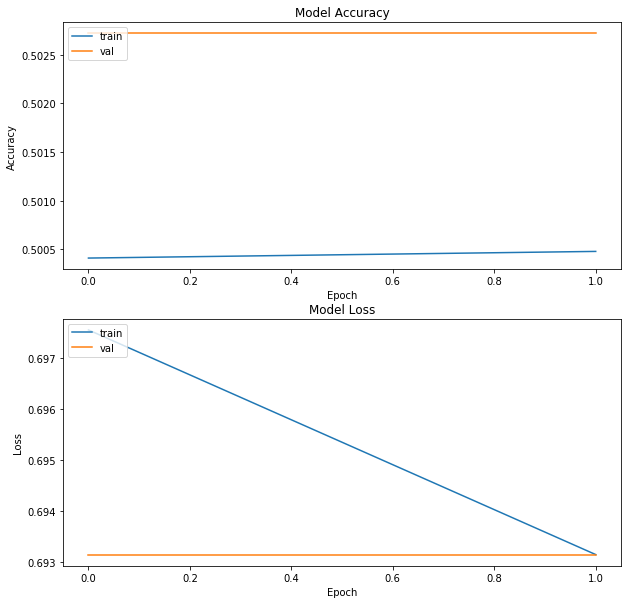

In [11]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

# My Model

In [12]:
# Define the architecture
ChestRESN50_model = Sequential()
ChestRESN50_model.add(Flatten(input_shape=train_DENSNET.shape[1:]))
# ChestRESN50_model.add(GlobalAveragePooling2D(input_shape=(train_RESNET.shape[1:])))

ChestRESN50_model.add(layers.Dense(256))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('relu'))
ChestRESN50_model.add(layers.Dropout(0.5))

ChestRESN50_model.add(layers.Dense(CLASSES))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('softmax'))

ChestRESN50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               12845312  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
_________________________________________________________________
batch_normalization_2 (Batch (None, 2)                 8         
__________

In [13]:
# Compile the model
adam = optimizers.Adam(lr=0.0001)
ChestRESN50_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [15]:
train_DENSNET.shape, train_targets.shape, validation_data.shape, validation_labels.shape

((14640, 7, 7, 1024), (14654, 2), (2208, 7, 7, 1024), (2220, 2))

In [40]:
# Train the model with with the best weights.

# used to save the model that attains the best validation loss
checkpointer = ModelCheckpoint(filepath='weights.infiltration.DENSNET121.hdf5', verbose=1, save_best_only=True)

History = ChestRESN50_model.fit(train_DENSNET, train_targets[:14640], 
          validation_data=(validation_data, validation_labels[:2208]),
          epochs=10, batch_size=BATCH_SIZE, callbacks=[checkpointer], verbose=1, shuffle=False)

Train on 14640 samples, validate on 2208 samples
Epoch 1/10


 3248/14640 [=====>........................] - ETA: 4:13 - loss: 0.5870 - acc: 0.750 - ETA: 3:57 - loss: 0.5834 - acc: 0.781 - ETA: 3:47 - loss: 0.6092 - acc: 0.750 - ETA: 3:48 - loss: 0.6133 - acc: 0.734 - ETA: 3:58 - loss: 0.6015 - acc: 0.750 - ETA: 3:52 - loss: 0.6096 - acc: 0.739 - ETA: 3:50 - loss: 0.6089 - acc: 0.750 - ETA: 3:47 - loss: 0.6080 - acc: 0.750 - ETA: 3:52 - loss: 0.6151 - acc: 0.729 - ETA: 3:49 - loss: 0.6180 - acc: 0.725 - ETA: 3:46 - loss: 0.6212 - acc: 0.710 - ETA: 3:46 - loss: 0.6199 - acc: 0.703 - ETA: 3:49 - loss: 0.6228 - acc: 0.701 - ETA: 3:47 - loss: 0.6207 - acc: 0.709 - ETA: 3:46 - loss: 0.6228 - acc: 0.704 - ETA: 3:46 - loss: 0.6232 - acc: 0.703 - ETA: 3:48 - loss: 0.6245 - acc: 0.698 - ETA: 3:47 - loss: 0.6235 - acc: 0.701 - ETA: 3:46 - loss: 0.6223 - acc: 0.707 - ETA: 3:48 - loss: 0.6223 - acc: 0.712 - ETA: 3:48 - loss: 0.6248 - acc: 0.708 - ETA: 3:48 - loss: 0.6259 - acc: 0.707 - ETA: 3:48 - loss: 0.6244 - acc: 0.712 - ETA: 3:50 - loss: 0.6255 - acc: 0

 6512/14640 [============>.................] - ETA: 3:14 - loss: 0.6622 - acc: 0.612 - ETA: 3:14 - loss: 0.6622 - acc: 0.612 - ETA: 3:14 - loss: 0.6622 - acc: 0.612 - ETA: 3:14 - loss: 0.6627 - acc: 0.610 - ETA: 3:13 - loss: 0.6625 - acc: 0.611 - ETA: 3:13 - loss: 0.6623 - acc: 0.612 - ETA: 3:13 - loss: 0.6625 - acc: 0.611 - ETA: 3:13 - loss: 0.6624 - acc: 0.612 - ETA: 3:12 - loss: 0.6621 - acc: 0.613 - ETA: 3:12 - loss: 0.6619 - acc: 0.613 - ETA: 3:12 - loss: 0.6623 - acc: 0.612 - ETA: 3:11 - loss: 0.6624 - acc: 0.612 - ETA: 3:11 - loss: 0.6622 - acc: 0.613 - ETA: 3:11 - loss: 0.6619 - acc: 0.613 - ETA: 3:11 - loss: 0.6616 - acc: 0.614 - ETA: 3:10 - loss: 0.6616 - acc: 0.614 - ETA: 3:10 - loss: 0.6617 - acc: 0.613 - ETA: 3:10 - loss: 0.6618 - acc: 0.613 - ETA: 3:10 - loss: 0.6620 - acc: 0.613 - ETA: 3:10 - loss: 0.6620 - acc: 0.613 - ETA: 3:10 - loss: 0.6618 - acc: 0.613 - ETA: 3:10 - loss: 0.6620 - acc: 0.612 - ETA: 3:09 - loss: 0.6621 - acc: 0.612 - ETA: 3:09 - loss: 0.6619 - acc: 0

 9776/14640 [===================>..........] - ETA: 2:22 - loss: 0.6654 - acc: 0.599 - ETA: 2:22 - loss: 0.6657 - acc: 0.598 - ETA: 2:21 - loss: 0.6658 - acc: 0.598 - ETA: 2:21 - loss: 0.6657 - acc: 0.599 - ETA: 2:21 - loss: 0.6656 - acc: 0.599 - ETA: 2:21 - loss: 0.6657 - acc: 0.599 - ETA: 2:21 - loss: 0.6657 - acc: 0.599 - ETA: 2:20 - loss: 0.6657 - acc: 0.599 - ETA: 2:20 - loss: 0.6656 - acc: 0.599 - ETA: 2:20 - loss: 0.6658 - acc: 0.599 - ETA: 2:20 - loss: 0.6658 - acc: 0.599 - ETA: 2:19 - loss: 0.6658 - acc: 0.599 - ETA: 2:19 - loss: 0.6659 - acc: 0.599 - ETA: 2:19 - loss: 0.6659 - acc: 0.599 - ETA: 2:19 - loss: 0.6661 - acc: 0.598 - ETA: 2:19 - loss: 0.6662 - acc: 0.598 - ETA: 2:18 - loss: 0.6662 - acc: 0.598 - ETA: 2:18 - loss: 0.6664 - acc: 0.597 - ETA: 2:18 - loss: 0.6665 - acc: 0.597 - ETA: 2:18 - loss: 0.6664 - acc: 0.597 - ETA: 2:17 - loss: 0.6663 - acc: 0.597 - ETA: 2:17 - loss: 0.6661 - acc: 0.598 - ETA: 2:17 - loss: 0.6659 - acc: 0.598 - ETA: 2:17 - loss: 0.6661 - acc: 0

13136/14640 [=========================>....] - ETA: 1:27 - loss: 0.6681 - acc: 0.596 - ETA: 1:27 - loss: 0.6681 - acc: 0.596 - ETA: 1:27 - loss: 0.6682 - acc: 0.596 - ETA: 1:26 - loss: 0.6683 - acc: 0.595 - ETA: 1:26 - loss: 0.6683 - acc: 0.595 - ETA: 1:26 - loss: 0.6682 - acc: 0.596 - ETA: 1:25 - loss: 0.6680 - acc: 0.596 - ETA: 1:25 - loss: 0.6680 - acc: 0.596 - ETA: 1:25 - loss: 0.6681 - acc: 0.595 - ETA: 1:25 - loss: 0.6680 - acc: 0.595 - ETA: 1:24 - loss: 0.6679 - acc: 0.596 - ETA: 1:24 - loss: 0.6679 - acc: 0.596 - ETA: 1:24 - loss: 0.6679 - acc: 0.596 - ETA: 1:23 - loss: 0.6679 - acc: 0.595 - ETA: 1:23 - loss: 0.6679 - acc: 0.595 - ETA: 1:23 - loss: 0.6679 - acc: 0.596 - ETA: 1:23 - loss: 0.6678 - acc: 0.596 - ETA: 1:22 - loss: 0.6678 - acc: 0.596 - ETA: 1:22 - loss: 0.6678 - acc: 0.596 - ETA: 1:22 - loss: 0.6678 - acc: 0.596 - ETA: 1:21 - loss: 0.6678 - acc: 0.596 - ETA: 1:21 - loss: 0.6678 - acc: 0.596 - ETA: 1:21 - loss: 0.6678 - acc: 0.596 - ETA: 1:21 - loss: 0.6679 - acc: 0

14640/14640 [==============================] - ETA: 27s - loss: 0.6720 - acc: 0.58 - ETA: 27s - loss: 0.6720 - acc: 0.58 - ETA: 27s - loss: 0.6719 - acc: 0.58 - ETA: 26s - loss: 0.6720 - acc: 0.58 - ETA: 26s - loss: 0.6720 - acc: 0.58 - ETA: 26s - loss: 0.6721 - acc: 0.58 - ETA: 25s - loss: 0.6720 - acc: 0.58 - ETA: 25s - loss: 0.6720 - acc: 0.58 - ETA: 25s - loss: 0.6720 - acc: 0.58 - ETA: 25s - loss: 0.6720 - acc: 0.58 - ETA: 24s - loss: 0.6720 - acc: 0.58 - ETA: 24s - loss: 0.6721 - acc: 0.58 - ETA: 24s - loss: 0.6721 - acc: 0.58 - ETA: 23s - loss: 0.6721 - acc: 0.58 - ETA: 23s - loss: 0.6722 - acc: 0.58 - ETA: 23s - loss: 0.6723 - acc: 0.58 - ETA: 22s - loss: 0.6723 - acc: 0.58 - ETA: 22s - loss: 0.6722 - acc: 0.58 - ETA: 22s - loss: 0.6722 - acc: 0.58 - ETA: 22s - loss: 0.6722 - acc: 0.58 - ETA: 21s - loss: 0.6721 - acc: 0.58 - ETA: 21s - loss: 0.6721 - acc: 0.58 - ETA: 21s - loss: 0.6721 - acc: 0.58 - ETA: 20s - loss: 0.6722 - acc: 0.58 - ETA: 20s - loss: 0.6721 - acc: 0.58 - ETA

 3264/14640 [=====>........................] - ETA: 6:00 - loss: 0.5487 - acc: 0.750 - ETA: 5:06 - loss: 0.5543 - acc: 0.781 - ETA: 4:49 - loss: 0.5780 - acc: 0.729 - ETA: 4:40 - loss: 0.6085 - acc: 0.703 - ETA: 4:41 - loss: 0.6178 - acc: 0.675 - ETA: 4:54 - loss: 0.6233 - acc: 0.656 - ETA: 5:05 - loss: 0.6129 - acc: 0.678 - ETA: 4:58 - loss: 0.6168 - acc: 0.679 - ETA: 4:52 - loss: 0.6180 - acc: 0.687 - ETA: 4:47 - loss: 0.6166 - acc: 0.693 - ETA: 4:42 - loss: 0.6243 - acc: 0.681 - ETA: 4:37 - loss: 0.6207 - acc: 0.692 - ETA: 4:33 - loss: 0.6211 - acc: 0.692 - ETA: 4:31 - loss: 0.6150 - acc: 0.696 - ETA: 4:30 - loss: 0.6143 - acc: 0.704 - ETA: 4:27 - loss: 0.6173 - acc: 0.699 - ETA: 4:24 - loss: 0.6173 - acc: 0.698 - ETA: 4:23 - loss: 0.6146 - acc: 0.701 - ETA: 4:20 - loss: 0.6110 - acc: 0.703 - ETA: 4:18 - loss: 0.6107 - acc: 0.706 - ETA: 4:16 - loss: 0.6143 - acc: 0.699 - ETA: 4:15 - loss: 0.6171 - acc: 0.690 - ETA: 4:13 - loss: 0.6178 - acc: 0.690 - ETA: 4:11 - loss: 0.6156 - acc: 0

 6528/14640 [============>.................] - ETA: 3:09 - loss: 0.6207 - acc: 0.657 - ETA: 3:08 - loss: 0.6205 - acc: 0.657 - ETA: 3:08 - loss: 0.6209 - acc: 0.657 - ETA: 3:07 - loss: 0.6210 - acc: 0.656 - ETA: 3:07 - loss: 0.6207 - acc: 0.656 - ETA: 3:07 - loss: 0.6210 - acc: 0.656 - ETA: 3:06 - loss: 0.6206 - acc: 0.657 - ETA: 3:06 - loss: 0.6199 - acc: 0.657 - ETA: 3:05 - loss: 0.6197 - acc: 0.657 - ETA: 3:05 - loss: 0.6203 - acc: 0.656 - ETA: 3:05 - loss: 0.6205 - acc: 0.657 - ETA: 3:04 - loss: 0.6203 - acc: 0.658 - ETA: 3:04 - loss: 0.6201 - acc: 0.658 - ETA: 3:04 - loss: 0.6196 - acc: 0.658 - ETA: 3:04 - loss: 0.6189 - acc: 0.659 - ETA: 3:03 - loss: 0.6190 - acc: 0.658 - ETA: 3:03 - loss: 0.6190 - acc: 0.659 - ETA: 3:03 - loss: 0.6191 - acc: 0.659 - ETA: 3:02 - loss: 0.6189 - acc: 0.660 - ETA: 3:02 - loss: 0.6192 - acc: 0.659 - ETA: 3:02 - loss: 0.6198 - acc: 0.659 - ETA: 3:02 - loss: 0.6197 - acc: 0.660 - ETA: 3:02 - loss: 0.6191 - acc: 0.660 - ETA: 3:01 - loss: 0.6193 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:25 - loss: 0.6262 - acc: 0.649 - ETA: 2:25 - loss: 0.6263 - acc: 0.648 - ETA: 2:25 - loss: 0.6262 - acc: 0.649 - ETA: 2:24 - loss: 0.6263 - acc: 0.648 - ETA: 2:24 - loss: 0.6265 - acc: 0.648 - ETA: 2:24 - loss: 0.6265 - acc: 0.648 - ETA: 2:24 - loss: 0.6265 - acc: 0.648 - ETA: 2:23 - loss: 0.6265 - acc: 0.648 - ETA: 2:23 - loss: 0.6267 - acc: 0.648 - ETA: 2:23 - loss: 0.6269 - acc: 0.647 - ETA: 2:22 - loss: 0.6270 - acc: 0.647 - ETA: 2:22 - loss: 0.6268 - acc: 0.647 - ETA: 2:22 - loss: 0.6266 - acc: 0.648 - ETA: 2:22 - loss: 0.6266 - acc: 0.648 - ETA: 2:21 - loss: 0.6264 - acc: 0.648 - ETA: 2:21 - loss: 0.6266 - acc: 0.648 - ETA: 2:21 - loss: 0.6265 - acc: 0.648 - ETA: 2:20 - loss: 0.6266 - acc: 0.647 - ETA: 2:20 - loss: 0.6268 - acc: 0.647 - ETA: 2:20 - loss: 0.6268 - acc: 0.647 - ETA: 2:19 - loss: 0.6269 - acc: 0.647 - ETA: 2:19 - loss: 0.6268 - acc: 0.647 - ETA: 2:19 - loss: 0.6269 - acc: 0.647 - ETA: 2:19 - loss: 0.6267 - acc: 0

13168/14640 [=========================>....] - ETA: 1:22 - loss: 0.6280 - acc: 0.645 - ETA: 1:22 - loss: 0.6280 - acc: 0.645 - ETA: 1:22 - loss: 0.6280 - acc: 0.645 - ETA: 1:22 - loss: 0.6280 - acc: 0.645 - ETA: 1:21 - loss: 0.6279 - acc: 0.645 - ETA: 1:21 - loss: 0.6279 - acc: 0.645 - ETA: 1:21 - loss: 0.6281 - acc: 0.645 - ETA: 1:20 - loss: 0.6283 - acc: 0.645 - ETA: 1:20 - loss: 0.6283 - acc: 0.645 - ETA: 1:20 - loss: 0.6282 - acc: 0.645 - ETA: 1:19 - loss: 0.6283 - acc: 0.645 - ETA: 1:19 - loss: 0.6284 - acc: 0.644 - ETA: 1:19 - loss: 0.6284 - acc: 0.645 - ETA: 1:19 - loss: 0.6285 - acc: 0.644 - ETA: 1:18 - loss: 0.6285 - acc: 0.644 - ETA: 1:18 - loss: 0.6282 - acc: 0.645 - ETA: 1:18 - loss: 0.6281 - acc: 0.645 - ETA: 1:17 - loss: 0.6281 - acc: 0.645 - ETA: 1:17 - loss: 0.6280 - acc: 0.645 - ETA: 1:17 - loss: 0.6280 - acc: 0.645 - ETA: 1:17 - loss: 0.6279 - acc: 0.645 - ETA: 1:16 - loss: 0.6281 - acc: 0.645 - ETA: 1:16 - loss: 0.6281 - acc: 0.645 - ETA: 1:16 - loss: 0.6281 - acc: 0

14640/14640 [==============================] - ETA: 23s - loss: 0.6317 - acc: 0.63 - ETA: 23s - loss: 0.6319 - acc: 0.63 - ETA: 23s - loss: 0.6319 - acc: 0.63 - ETA: 23s - loss: 0.6319 - acc: 0.63 - ETA: 22s - loss: 0.6320 - acc: 0.63 - ETA: 22s - loss: 0.6319 - acc: 0.63 - ETA: 22s - loss: 0.6319 - acc: 0.63 - ETA: 21s - loss: 0.6320 - acc: 0.63 - ETA: 21s - loss: 0.6320 - acc: 0.63 - ETA: 21s - loss: 0.6319 - acc: 0.63 - ETA: 21s - loss: 0.6318 - acc: 0.63 - ETA: 20s - loss: 0.6316 - acc: 0.63 - ETA: 20s - loss: 0.6318 - acc: 0.63 - ETA: 20s - loss: 0.6319 - acc: 0.63 - ETA: 20s - loss: 0.6320 - acc: 0.63 - ETA: 19s - loss: 0.6319 - acc: 0.63 - ETA: 19s - loss: 0.6319 - acc: 0.63 - ETA: 19s - loss: 0.6319 - acc: 0.63 - ETA: 19s - loss: 0.6318 - acc: 0.63 - ETA: 18s - loss: 0.6318 - acc: 0.63 - ETA: 18s - loss: 0.6318 - acc: 0.63 - ETA: 18s - loss: 0.6319 - acc: 0.63 - ETA: 17s - loss: 0.6318 - acc: 0.63 - ETA: 17s - loss: 0.6318 - acc: 0.63 - ETA: 17s - loss: 0.6318 - acc: 0.63 - ETA

 3264/14640 [=====>........................] - ETA: 3:29 - loss: 0.4942 - acc: 0.875 - ETA: 3:31 - loss: 0.5087 - acc: 0.843 - ETA: 3:31 - loss: 0.5547 - acc: 0.770 - ETA: 3:32 - loss: 0.5786 - acc: 0.718 - ETA: 3:33 - loss: 0.5819 - acc: 0.737 - ETA: 3:31 - loss: 0.5986 - acc: 0.708 - ETA: 3:30 - loss: 0.5870 - acc: 0.732 - ETA: 3:31 - loss: 0.6084 - acc: 0.695 - ETA: 3:30 - loss: 0.6183 - acc: 0.687 - ETA: 3:29 - loss: 0.6128 - acc: 0.706 - ETA: 3:28 - loss: 0.6157 - acc: 0.715 - ETA: 3:27 - loss: 0.6077 - acc: 0.713 - ETA: 3:26 - loss: 0.6089 - acc: 0.701 - ETA: 3:24 - loss: 0.5934 - acc: 0.723 - ETA: 3:23 - loss: 0.5940 - acc: 0.720 - ETA: 3:22 - loss: 0.5943 - acc: 0.714 - ETA: 3:21 - loss: 0.5956 - acc: 0.709 - ETA: 3:21 - loss: 0.5943 - acc: 0.708 - ETA: 3:20 - loss: 0.5834 - acc: 0.717 - ETA: 3:19 - loss: 0.5850 - acc: 0.712 - ETA: 3:19 - loss: 0.5916 - acc: 0.696 - ETA: 3:18 - loss: 0.5939 - acc: 0.693 - ETA: 3:17 - loss: 0.5938 - acc: 0.690 - ETA: 3:17 - loss: 0.5921 - acc: 0

 6528/14640 [============>.................] - ETA: 2:39 - loss: 0.5638 - acc: 0.724 - ETA: 2:39 - loss: 0.5639 - acc: 0.724 - ETA: 2:39 - loss: 0.5649 - acc: 0.723 - ETA: 2:38 - loss: 0.5658 - acc: 0.722 - ETA: 2:38 - loss: 0.5654 - acc: 0.722 - ETA: 2:38 - loss: 0.5663 - acc: 0.720 - ETA: 2:38 - loss: 0.5661 - acc: 0.720 - ETA: 2:38 - loss: 0.5658 - acc: 0.721 - ETA: 2:37 - loss: 0.5664 - acc: 0.721 - ETA: 2:37 - loss: 0.5668 - acc: 0.720 - ETA: 2:37 - loss: 0.5663 - acc: 0.721 - ETA: 2:37 - loss: 0.5657 - acc: 0.721 - ETA: 2:37 - loss: 0.5652 - acc: 0.722 - ETA: 2:36 - loss: 0.5647 - acc: 0.723 - ETA: 2:36 - loss: 0.5642 - acc: 0.723 - ETA: 2:36 - loss: 0.5647 - acc: 0.722 - ETA: 2:36 - loss: 0.5653 - acc: 0.721 - ETA: 2:36 - loss: 0.5653 - acc: 0.722 - ETA: 2:36 - loss: 0.5656 - acc: 0.722 - ETA: 2:35 - loss: 0.5654 - acc: 0.721 - ETA: 2:35 - loss: 0.5649 - acc: 0.722 - ETA: 2:35 - loss: 0.5650 - acc: 0.722 - ETA: 2:35 - loss: 0.5642 - acc: 0.723 - ETA: 2:34 - loss: 0.5648 - acc: 0

 9792/14640 [===================>..........] - ETA: 1:55 - loss: 0.5666 - acc: 0.710 - ETA: 1:55 - loss: 0.5668 - acc: 0.709 - ETA: 1:54 - loss: 0.5669 - acc: 0.710 - ETA: 1:54 - loss: 0.5667 - acc: 0.710 - ETA: 1:54 - loss: 0.5673 - acc: 0.709 - ETA: 1:54 - loss: 0.5672 - acc: 0.709 - ETA: 1:53 - loss: 0.5672 - acc: 0.710 - ETA: 1:53 - loss: 0.5674 - acc: 0.709 - ETA: 1:53 - loss: 0.5676 - acc: 0.709 - ETA: 1:53 - loss: 0.5680 - acc: 0.709 - ETA: 1:53 - loss: 0.5680 - acc: 0.709 - ETA: 1:53 - loss: 0.5681 - acc: 0.709 - ETA: 1:52 - loss: 0.5684 - acc: 0.709 - ETA: 1:52 - loss: 0.5684 - acc: 0.709 - ETA: 1:52 - loss: 0.5684 - acc: 0.709 - ETA: 1:52 - loss: 0.5682 - acc: 0.709 - ETA: 1:52 - loss: 0.5682 - acc: 0.709 - ETA: 1:51 - loss: 0.5684 - acc: 0.709 - ETA: 1:51 - loss: 0.5688 - acc: 0.709 - ETA: 1:51 - loss: 0.5688 - acc: 0.708 - ETA: 1:51 - loss: 0.5687 - acc: 0.708 - ETA: 1:50 - loss: 0.5685 - acc: 0.709 - ETA: 1:50 - loss: 0.5683 - acc: 0.709 - ETA: 1:50 - loss: 0.5679 - acc: 0

13200/14640 [==========================>...] - ETA: 1:09 - loss: 0.5699 - acc: 0.705 - ETA: 1:09 - loss: 0.5699 - acc: 0.705 - ETA: 1:09 - loss: 0.5698 - acc: 0.705 - ETA: 1:09 - loss: 0.5697 - acc: 0.706 - ETA: 1:08 - loss: 0.5695 - acc: 0.706 - ETA: 1:08 - loss: 0.5693 - acc: 0.706 - ETA: 1:08 - loss: 0.5693 - acc: 0.706 - ETA: 1:08 - loss: 0.5696 - acc: 0.706 - ETA: 1:08 - loss: 0.5696 - acc: 0.706 - ETA: 1:07 - loss: 0.5695 - acc: 0.706 - ETA: 1:07 - loss: 0.5696 - acc: 0.706 - ETA: 1:07 - loss: 0.5700 - acc: 0.705 - ETA: 1:07 - loss: 0.5699 - acc: 0.706 - ETA: 1:06 - loss: 0.5697 - acc: 0.706 - ETA: 1:06 - loss: 0.5696 - acc: 0.706 - ETA: 1:06 - loss: 0.5693 - acc: 0.706 - ETA: 1:06 - loss: 0.5695 - acc: 0.706 - ETA: 1:05 - loss: 0.5696 - acc: 0.706 - ETA: 1:05 - loss: 0.5695 - acc: 0.706 - ETA: 1:05 - loss: 0.5694 - acc: 0.706 - ETA: 1:05 - loss: 0.5693 - acc: 0.706 - ETA: 1:05 - loss: 0.5693 - acc: 0.706 - ETA: 1:04 - loss: 0.5692 - acc: 0.706 - ETA: 1:04 - loss: 0.5694 - acc: 0

14640/14640 [==============================] - ETA: 20s - loss: 0.5740 - acc: 0.70 - ETA: 20s - loss: 0.5740 - acc: 0.70 - ETA: 20s - loss: 0.5740 - acc: 0.70 - ETA: 19s - loss: 0.5739 - acc: 0.70 - ETA: 19s - loss: 0.5739 - acc: 0.70 - ETA: 19s - loss: 0.5741 - acc: 0.70 - ETA: 19s - loss: 0.5743 - acc: 0.70 - ETA: 18s - loss: 0.5741 - acc: 0.70 - ETA: 18s - loss: 0.5739 - acc: 0.70 - ETA: 18s - loss: 0.5739 - acc: 0.70 - ETA: 18s - loss: 0.5740 - acc: 0.70 - ETA: 18s - loss: 0.5741 - acc: 0.70 - ETA: 17s - loss: 0.5741 - acc: 0.70 - ETA: 17s - loss: 0.5741 - acc: 0.70 - ETA: 17s - loss: 0.5741 - acc: 0.70 - ETA: 17s - loss: 0.5741 - acc: 0.70 - ETA: 16s - loss: 0.5741 - acc: 0.70 - ETA: 16s - loss: 0.5741 - acc: 0.70 - ETA: 16s - loss: 0.5741 - acc: 0.70 - ETA: 16s - loss: 0.5742 - acc: 0.70 - ETA: 15s - loss: 0.5740 - acc: 0.70 - ETA: 15s - loss: 0.5741 - acc: 0.70 - ETA: 15s - loss: 0.5741 - acc: 0.70 - ETA: 15s - loss: 0.5741 - acc: 0.70 - ETA: 15s - loss: 0.5743 - acc: 0.70 - ETA

 3264/14640 [=====>........................] - ETA: 4:58 - loss: 0.3780 - acc: 0.875 - ETA: 4:41 - loss: 0.4541 - acc: 0.843 - ETA: 4:37 - loss: 0.4968 - acc: 0.791 - ETA: 4:27 - loss: 0.5157 - acc: 0.781 - ETA: 4:22 - loss: 0.5161 - acc: 0.800 - ETA: 4:15 - loss: 0.5327 - acc: 0.791 - ETA: 4:19 - loss: 0.5263 - acc: 0.794 - ETA: 4:14 - loss: 0.5325 - acc: 0.773 - ETA: 4:10 - loss: 0.5321 - acc: 0.770 - ETA: 4:06 - loss: 0.5356 - acc: 0.768 - ETA: 4:02 - loss: 0.5491 - acc: 0.750 - ETA: 4:00 - loss: 0.5442 - acc: 0.750 - ETA: 3:57 - loss: 0.5380 - acc: 0.745 - ETA: 3:56 - loss: 0.5319 - acc: 0.758 - ETA: 3:54 - loss: 0.5280 - acc: 0.766 - ETA: 3:54 - loss: 0.5261 - acc: 0.769 - ETA: 3:54 - loss: 0.5266 - acc: 0.768 - ETA: 3:52 - loss: 0.5296 - acc: 0.763 - ETA: 3:51 - loss: 0.5223 - acc: 0.769 - ETA: 3:51 - loss: 0.5256 - acc: 0.765 - ETA: 3:51 - loss: 0.5402 - acc: 0.738 - ETA: 3:49 - loss: 0.5378 - acc: 0.738 - ETA: 3:48 - loss: 0.5342 - acc: 0.744 - ETA: 3:48 - loss: 0.5301 - acc: 0

 6528/14640 [============>.................] - ETA: 2:44 - loss: 0.4938 - acc: 0.761 - ETA: 2:44 - loss: 0.4938 - acc: 0.760 - ETA: 2:43 - loss: 0.4935 - acc: 0.760 - ETA: 2:43 - loss: 0.4939 - acc: 0.760 - ETA: 2:43 - loss: 0.4936 - acc: 0.760 - ETA: 2:43 - loss: 0.4934 - acc: 0.760 - ETA: 2:42 - loss: 0.4937 - acc: 0.760 - ETA: 2:42 - loss: 0.4935 - acc: 0.760 - ETA: 2:42 - loss: 0.4938 - acc: 0.760 - ETA: 2:42 - loss: 0.4946 - acc: 0.759 - ETA: 2:42 - loss: 0.4951 - acc: 0.759 - ETA: 2:41 - loss: 0.4945 - acc: 0.759 - ETA: 2:41 - loss: 0.4942 - acc: 0.759 - ETA: 2:41 - loss: 0.4932 - acc: 0.760 - ETA: 2:41 - loss: 0.4930 - acc: 0.760 - ETA: 2:40 - loss: 0.4927 - acc: 0.760 - ETA: 2:40 - loss: 0.4935 - acc: 0.759 - ETA: 2:40 - loss: 0.4931 - acc: 0.760 - ETA: 2:40 - loss: 0.4928 - acc: 0.760 - ETA: 2:40 - loss: 0.4924 - acc: 0.761 - ETA: 2:40 - loss: 0.4921 - acc: 0.761 - ETA: 2:40 - loss: 0.4919 - acc: 0.761 - ETA: 2:39 - loss: 0.4915 - acc: 0.762 - ETA: 2:39 - loss: 0.4912 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:04 - loss: 0.4962 - acc: 0.761 - ETA: 2:04 - loss: 0.4968 - acc: 0.761 - ETA: 2:04 - loss: 0.4969 - acc: 0.761 - ETA: 2:04 - loss: 0.4969 - acc: 0.761 - ETA: 2:03 - loss: 0.4973 - acc: 0.761 - ETA: 2:03 - loss: 0.4974 - acc: 0.761 - ETA: 2:03 - loss: 0.4972 - acc: 0.761 - ETA: 2:03 - loss: 0.4970 - acc: 0.761 - ETA: 2:02 - loss: 0.4981 - acc: 0.760 - ETA: 2:02 - loss: 0.4982 - acc: 0.761 - ETA: 2:02 - loss: 0.4983 - acc: 0.760 - ETA: 2:02 - loss: 0.4987 - acc: 0.760 - ETA: 2:02 - loss: 0.4986 - acc: 0.760 - ETA: 2:01 - loss: 0.4986 - acc: 0.760 - ETA: 2:01 - loss: 0.4988 - acc: 0.760 - ETA: 2:01 - loss: 0.4987 - acc: 0.760 - ETA: 2:01 - loss: 0.4991 - acc: 0.760 - ETA: 2:00 - loss: 0.4991 - acc: 0.760 - ETA: 2:00 - loss: 0.4992 - acc: 0.760 - ETA: 2:00 - loss: 0.4991 - acc: 0.760 - ETA: 2:00 - loss: 0.4989 - acc: 0.761 - ETA: 2:00 - loss: 0.4986 - acc: 0.761 - ETA: 1:59 - loss: 0.4987 - acc: 0.761 - ETA: 1:59 - loss: 0.4985 - acc: 0

13168/14640 [=========================>....] - ETA: 1:17 - loss: 0.5000 - acc: 0.760 - ETA: 1:16 - loss: 0.5002 - acc: 0.760 - ETA: 1:16 - loss: 0.4999 - acc: 0.760 - ETA: 1:16 - loss: 0.4998 - acc: 0.761 - ETA: 1:16 - loss: 0.4996 - acc: 0.761 - ETA: 1:15 - loss: 0.4994 - acc: 0.761 - ETA: 1:15 - loss: 0.4993 - acc: 0.761 - ETA: 1:15 - loss: 0.4995 - acc: 0.761 - ETA: 1:15 - loss: 0.4998 - acc: 0.761 - ETA: 1:14 - loss: 0.4995 - acc: 0.761 - ETA: 1:14 - loss: 0.4998 - acc: 0.761 - ETA: 1:14 - loss: 0.5000 - acc: 0.760 - ETA: 1:14 - loss: 0.5000 - acc: 0.761 - ETA: 1:13 - loss: 0.4997 - acc: 0.761 - ETA: 1:13 - loss: 0.4997 - acc: 0.761 - ETA: 1:13 - loss: 0.4995 - acc: 0.761 - ETA: 1:13 - loss: 0.4997 - acc: 0.761 - ETA: 1:12 - loss: 0.4995 - acc: 0.761 - ETA: 1:12 - loss: 0.4997 - acc: 0.761 - ETA: 1:12 - loss: 0.4996 - acc: 0.761 - ETA: 1:11 - loss: 0.4999 - acc: 0.761 - ETA: 1:11 - loss: 0.5002 - acc: 0.760 - ETA: 1:11 - loss: 0.5000 - acc: 0.760 - ETA: 1:11 - loss: 0.5001 - acc: 0

14640/14640 [==============================] - ETA: 23s - loss: 0.5034 - acc: 0.75 - ETA: 22s - loss: 0.5038 - acc: 0.75 - ETA: 22s - loss: 0.5039 - acc: 0.75 - ETA: 22s - loss: 0.5041 - acc: 0.75 - ETA: 22s - loss: 0.5043 - acc: 0.75 - ETA: 21s - loss: 0.5043 - acc: 0.75 - ETA: 21s - loss: 0.5045 - acc: 0.75 - ETA: 21s - loss: 0.5047 - acc: 0.75 - ETA: 20s - loss: 0.5048 - acc: 0.75 - ETA: 20s - loss: 0.5048 - acc: 0.75 - ETA: 20s - loss: 0.5047 - acc: 0.75 - ETA: 20s - loss: 0.5044 - acc: 0.75 - ETA: 19s - loss: 0.5045 - acc: 0.75 - ETA: 19s - loss: 0.5046 - acc: 0.75 - ETA: 19s - loss: 0.5046 - acc: 0.75 - ETA: 19s - loss: 0.5045 - acc: 0.75 - ETA: 18s - loss: 0.5045 - acc: 0.75 - ETA: 18s - loss: 0.5044 - acc: 0.75 - ETA: 18s - loss: 0.5046 - acc: 0.75 - ETA: 18s - loss: 0.5046 - acc: 0.75 - ETA: 17s - loss: 0.5045 - acc: 0.75 - ETA: 17s - loss: 0.5045 - acc: 0.75 - ETA: 17s - loss: 0.5046 - acc: 0.75 - ETA: 17s - loss: 0.5047 - acc: 0.75 - ETA: 16s - loss: 0.5047 - acc: 0.75 - ETA

 3264/14640 [=====>........................] - ETA: 4:23 - loss: 0.4929 - acc: 0.687 - ETA: 4:21 - loss: 0.4474 - acc: 0.750 - ETA: 4:10 - loss: 0.4664 - acc: 0.770 - ETA: 4:14 - loss: 0.4848 - acc: 0.750 - ETA: 4:16 - loss: 0.4477 - acc: 0.787 - ETA: 4:19 - loss: 0.4445 - acc: 0.791 - ETA: 4:23 - loss: 0.4323 - acc: 0.803 - ETA: 4:22 - loss: 0.4409 - acc: 0.796 - ETA: 4:22 - loss: 0.4509 - acc: 0.805 - ETA: 4:20 - loss: 0.4547 - acc: 0.806 - ETA: 4:18 - loss: 0.4767 - acc: 0.784 - ETA: 4:18 - loss: 0.4733 - acc: 0.786 - ETA: 4:15 - loss: 0.4694 - acc: 0.788 - ETA: 4:13 - loss: 0.4618 - acc: 0.794 - ETA: 4:11 - loss: 0.4662 - acc: 0.787 - ETA: 4:09 - loss: 0.4752 - acc: 0.785 - ETA: 4:08 - loss: 0.4779 - acc: 0.775 - ETA: 4:06 - loss: 0.4688 - acc: 0.784 - ETA: 4:06 - loss: 0.4625 - acc: 0.789 - ETA: 4:05 - loss: 0.4637 - acc: 0.787 - ETA: 4:06 - loss: 0.4693 - acc: 0.785 - ETA: 4:05 - loss: 0.4713 - acc: 0.778 - ETA: 4:05 - loss: 0.4722 - acc: 0.777 - ETA: 4:05 - loss: 0.4683 - acc: 0

 6528/14640 [============>.................] - ETA: 3:05 - loss: 0.4289 - acc: 0.806 - ETA: 3:05 - loss: 0.4289 - acc: 0.806 - ETA: 3:05 - loss: 0.4292 - acc: 0.805 - ETA: 3:04 - loss: 0.4298 - acc: 0.805 - ETA: 3:04 - loss: 0.4296 - acc: 0.805 - ETA: 3:04 - loss: 0.4298 - acc: 0.805 - ETA: 3:04 - loss: 0.4292 - acc: 0.805 - ETA: 3:03 - loss: 0.4287 - acc: 0.806 - ETA: 3:03 - loss: 0.4298 - acc: 0.805 - ETA: 3:03 - loss: 0.4303 - acc: 0.805 - ETA: 3:02 - loss: 0.4302 - acc: 0.804 - ETA: 3:02 - loss: 0.4294 - acc: 0.805 - ETA: 3:02 - loss: 0.4288 - acc: 0.805 - ETA: 3:02 - loss: 0.4288 - acc: 0.805 - ETA: 3:01 - loss: 0.4284 - acc: 0.806 - ETA: 3:01 - loss: 0.4285 - acc: 0.806 - ETA: 3:01 - loss: 0.4293 - acc: 0.805 - ETA: 3:00 - loss: 0.4295 - acc: 0.805 - ETA: 3:00 - loss: 0.4295 - acc: 0.804 - ETA: 3:00 - loss: 0.4292 - acc: 0.805 - ETA: 2:59 - loss: 0.4295 - acc: 0.805 - ETA: 2:59 - loss: 0.4299 - acc: 0.805 - ETA: 2:59 - loss: 0.4295 - acc: 0.805 - ETA: 2:58 - loss: 0.4295 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:08 - loss: 0.4309 - acc: 0.804 - ETA: 2:08 - loss: 0.4316 - acc: 0.804 - ETA: 2:07 - loss: 0.4318 - acc: 0.803 - ETA: 2:07 - loss: 0.4317 - acc: 0.803 - ETA: 2:07 - loss: 0.4321 - acc: 0.803 - ETA: 2:07 - loss: 0.4330 - acc: 0.803 - ETA: 2:06 - loss: 0.4329 - acc: 0.803 - ETA: 2:06 - loss: 0.4328 - acc: 0.803 - ETA: 2:06 - loss: 0.4330 - acc: 0.803 - ETA: 2:06 - loss: 0.4332 - acc: 0.803 - ETA: 2:06 - loss: 0.4335 - acc: 0.803 - ETA: 2:06 - loss: 0.4335 - acc: 0.803 - ETA: 2:05 - loss: 0.4336 - acc: 0.802 - ETA: 2:05 - loss: 0.4335 - acc: 0.802 - ETA: 2:05 - loss: 0.4335 - acc: 0.802 - ETA: 2:05 - loss: 0.4332 - acc: 0.802 - ETA: 2:05 - loss: 0.4331 - acc: 0.802 - ETA: 2:05 - loss: 0.4335 - acc: 0.802 - ETA: 2:05 - loss: 0.4337 - acc: 0.802 - ETA: 2:04 - loss: 0.4340 - acc: 0.802 - ETA: 2:04 - loss: 0.4337 - acc: 0.802 - ETA: 2:04 - loss: 0.4336 - acc: 0.802 - ETA: 2:04 - loss: 0.4333 - acc: 0.802 - ETA: 2:04 - loss: 0.4330 - acc: 0

13168/14640 [=========================>....] - ETA: 1:21 - loss: 0.4372 - acc: 0.801 - ETA: 1:21 - loss: 0.4371 - acc: 0.801 - ETA: 1:21 - loss: 0.4371 - acc: 0.801 - ETA: 1:21 - loss: 0.4369 - acc: 0.801 - ETA: 1:20 - loss: 0.4369 - acc: 0.802 - ETA: 1:20 - loss: 0.4366 - acc: 0.802 - ETA: 1:20 - loss: 0.4367 - acc: 0.802 - ETA: 1:19 - loss: 0.4370 - acc: 0.802 - ETA: 1:19 - loss: 0.4370 - acc: 0.802 - ETA: 1:19 - loss: 0.4369 - acc: 0.802 - ETA: 1:19 - loss: 0.4368 - acc: 0.802 - ETA: 1:18 - loss: 0.4368 - acc: 0.802 - ETA: 1:18 - loss: 0.4369 - acc: 0.802 - ETA: 1:18 - loss: 0.4370 - acc: 0.802 - ETA: 1:18 - loss: 0.4369 - acc: 0.802 - ETA: 1:17 - loss: 0.4365 - acc: 0.802 - ETA: 1:17 - loss: 0.4365 - acc: 0.802 - ETA: 1:17 - loss: 0.4367 - acc: 0.802 - ETA: 1:16 - loss: 0.4369 - acc: 0.802 - ETA: 1:16 - loss: 0.4367 - acc: 0.802 - ETA: 1:16 - loss: 0.4366 - acc: 0.802 - ETA: 1:16 - loss: 0.4367 - acc: 0.802 - ETA: 1:15 - loss: 0.4366 - acc: 0.802 - ETA: 1:15 - loss: 0.4366 - acc: 0

14640/14640 [==============================] - ETA: 24s - loss: 0.4374 - acc: 0.80 - ETA: 24s - loss: 0.4374 - acc: 0.80 - ETA: 23s - loss: 0.4375 - acc: 0.80 - ETA: 23s - loss: 0.4374 - acc: 0.80 - ETA: 23s - loss: 0.4374 - acc: 0.80 - ETA: 23s - loss: 0.4375 - acc: 0.80 - ETA: 22s - loss: 0.4376 - acc: 0.80 - ETA: 22s - loss: 0.4377 - acc: 0.80 - ETA: 22s - loss: 0.4377 - acc: 0.80 - ETA: 21s - loss: 0.4376 - acc: 0.80 - ETA: 21s - loss: 0.4377 - acc: 0.80 - ETA: 21s - loss: 0.4376 - acc: 0.80 - ETA: 21s - loss: 0.4377 - acc: 0.80 - ETA: 20s - loss: 0.4378 - acc: 0.80 - ETA: 20s - loss: 0.4378 - acc: 0.80 - ETA: 20s - loss: 0.4378 - acc: 0.80 - ETA: 20s - loss: 0.4377 - acc: 0.80 - ETA: 19s - loss: 0.4376 - acc: 0.80 - ETA: 19s - loss: 0.4375 - acc: 0.80 - ETA: 19s - loss: 0.4374 - acc: 0.80 - ETA: 19s - loss: 0.4376 - acc: 0.80 - ETA: 18s - loss: 0.4379 - acc: 0.80 - ETA: 18s - loss: 0.4377 - acc: 0.80 - ETA: 18s - loss: 0.4378 - acc: 0.80 - ETA: 17s - loss: 0.4378 - acc: 0.80 - ETA

 3264/14640 [=====>........................] - ETA: 4:12 - loss: 0.4488 - acc: 0.875 - ETA: 4:19 - loss: 0.4594 - acc: 0.843 - ETA: 4:19 - loss: 0.4729 - acc: 0.833 - ETA: 4:23 - loss: 0.4763 - acc: 0.812 - ETA: 4:25 - loss: 0.4867 - acc: 0.800 - ETA: 4:25 - loss: 0.4607 - acc: 0.812 - ETA: 4:30 - loss: 0.4387 - acc: 0.830 - ETA: 4:31 - loss: 0.4311 - acc: 0.828 - ETA: 4:32 - loss: 0.4300 - acc: 0.826 - ETA: 4:31 - loss: 0.4154 - acc: 0.831 - ETA: 4:33 - loss: 0.4220 - acc: 0.829 - ETA: 4:34 - loss: 0.4235 - acc: 0.828 - ETA: 4:33 - loss: 0.4130 - acc: 0.836 - ETA: 4:31 - loss: 0.4082 - acc: 0.839 - ETA: 4:30 - loss: 0.4159 - acc: 0.833 - ETA: 4:29 - loss: 0.4086 - acc: 0.839 - ETA: 4:29 - loss: 0.4079 - acc: 0.845 - ETA: 4:26 - loss: 0.4115 - acc: 0.843 - ETA: 4:26 - loss: 0.4062 - acc: 0.838 - ETA: 4:28 - loss: 0.4012 - acc: 0.843 - ETA: 4:29 - loss: 0.4013 - acc: 0.842 - ETA: 4:30 - loss: 0.3991 - acc: 0.843 - ETA: 4:30 - loss: 0.3996 - acc: 0.847 - ETA: 4:28 - loss: 0.3949 - acc: 0

 6528/14640 [============>.................] - ETA: 3:14 - loss: 0.3774 - acc: 0.849 - ETA: 3:13 - loss: 0.3771 - acc: 0.849 - ETA: 3:13 - loss: 0.3769 - acc: 0.849 - ETA: 3:13 - loss: 0.3777 - acc: 0.849 - ETA: 3:13 - loss: 0.3772 - acc: 0.849 - ETA: 3:12 - loss: 0.3772 - acc: 0.849 - ETA: 3:12 - loss: 0.3777 - acc: 0.849 - ETA: 3:11 - loss: 0.3773 - acc: 0.849 - ETA: 3:11 - loss: 0.3772 - acc: 0.849 - ETA: 3:11 - loss: 0.3779 - acc: 0.849 - ETA: 3:11 - loss: 0.3782 - acc: 0.849 - ETA: 3:10 - loss: 0.3779 - acc: 0.849 - ETA: 3:10 - loss: 0.3779 - acc: 0.849 - ETA: 3:10 - loss: 0.3783 - acc: 0.848 - ETA: 3:09 - loss: 0.3778 - acc: 0.848 - ETA: 3:09 - loss: 0.3770 - acc: 0.849 - ETA: 3:09 - loss: 0.3767 - acc: 0.849 - ETA: 3:08 - loss: 0.3772 - acc: 0.849 - ETA: 3:08 - loss: 0.3772 - acc: 0.849 - ETA: 3:08 - loss: 0.3766 - acc: 0.849 - ETA: 3:08 - loss: 0.3767 - acc: 0.849 - ETA: 3:07 - loss: 0.3765 - acc: 0.849 - ETA: 3:07 - loss: 0.3759 - acc: 0.849 - ETA: 3:07 - loss: 0.3761 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:17 - loss: 0.3770 - acc: 0.847 - ETA: 2:17 - loss: 0.3777 - acc: 0.846 - ETA: 2:16 - loss: 0.3776 - acc: 0.846 - ETA: 2:16 - loss: 0.3775 - acc: 0.846 - ETA: 2:16 - loss: 0.3779 - acc: 0.846 - ETA: 2:16 - loss: 0.3785 - acc: 0.846 - ETA: 2:15 - loss: 0.3784 - acc: 0.846 - ETA: 2:15 - loss: 0.3784 - acc: 0.846 - ETA: 2:15 - loss: 0.3786 - acc: 0.846 - ETA: 2:14 - loss: 0.3786 - acc: 0.846 - ETA: 2:14 - loss: 0.3787 - acc: 0.846 - ETA: 2:14 - loss: 0.3787 - acc: 0.846 - ETA: 2:13 - loss: 0.3788 - acc: 0.846 - ETA: 2:13 - loss: 0.3786 - acc: 0.846 - ETA: 2:13 - loss: 0.3786 - acc: 0.846 - ETA: 2:13 - loss: 0.3786 - acc: 0.846 - ETA: 2:12 - loss: 0.3785 - acc: 0.846 - ETA: 2:12 - loss: 0.3786 - acc: 0.846 - ETA: 2:12 - loss: 0.3786 - acc: 0.846 - ETA: 2:12 - loss: 0.3787 - acc: 0.846 - ETA: 2:11 - loss: 0.3786 - acc: 0.846 - ETA: 2:11 - loss: 0.3783 - acc: 0.846 - ETA: 2:11 - loss: 0.3781 - acc: 0.846 - ETA: 2:10 - loss: 0.3779 - acc: 0

13168/14640 [=========================>....] - ETA: 1:18 - loss: 0.3751 - acc: 0.849 - ETA: 1:18 - loss: 0.3753 - acc: 0.849 - ETA: 1:18 - loss: 0.3753 - acc: 0.849 - ETA: 1:18 - loss: 0.3753 - acc: 0.849 - ETA: 1:17 - loss: 0.3752 - acc: 0.849 - ETA: 1:17 - loss: 0.3751 - acc: 0.849 - ETA: 1:17 - loss: 0.3750 - acc: 0.849 - ETA: 1:17 - loss: 0.3755 - acc: 0.849 - ETA: 1:16 - loss: 0.3755 - acc: 0.849 - ETA: 1:16 - loss: 0.3753 - acc: 0.849 - ETA: 1:16 - loss: 0.3753 - acc: 0.849 - ETA: 1:15 - loss: 0.3753 - acc: 0.849 - ETA: 1:15 - loss: 0.3752 - acc: 0.849 - ETA: 1:15 - loss: 0.3751 - acc: 0.849 - ETA: 1:15 - loss: 0.3749 - acc: 0.849 - ETA: 1:14 - loss: 0.3746 - acc: 0.850 - ETA: 1:14 - loss: 0.3747 - acc: 0.850 - ETA: 1:14 - loss: 0.3747 - acc: 0.850 - ETA: 1:14 - loss: 0.3747 - acc: 0.850 - ETA: 1:13 - loss: 0.3747 - acc: 0.850 - ETA: 1:13 - loss: 0.3747 - acc: 0.850 - ETA: 1:13 - loss: 0.3751 - acc: 0.849 - ETA: 1:12 - loss: 0.3750 - acc: 0.849 - ETA: 1:12 - loss: 0.3753 - acc: 0

14640/14640 [==============================] - ETA: 23s - loss: 0.3788 - acc: 0.84 - ETA: 22s - loss: 0.3789 - acc: 0.84 - ETA: 22s - loss: 0.3789 - acc: 0.84 - ETA: 22s - loss: 0.3788 - acc: 0.84 - ETA: 22s - loss: 0.3789 - acc: 0.84 - ETA: 21s - loss: 0.3791 - acc: 0.84 - ETA: 21s - loss: 0.3792 - acc: 0.84 - ETA: 21s - loss: 0.3792 - acc: 0.84 - ETA: 21s - loss: 0.3794 - acc: 0.84 - ETA: 20s - loss: 0.3793 - acc: 0.84 - ETA: 20s - loss: 0.3791 - acc: 0.84 - ETA: 20s - loss: 0.3788 - acc: 0.84 - ETA: 20s - loss: 0.3790 - acc: 0.84 - ETA: 19s - loss: 0.3791 - acc: 0.84 - ETA: 19s - loss: 0.3791 - acc: 0.84 - ETA: 19s - loss: 0.3789 - acc: 0.84 - ETA: 19s - loss: 0.3789 - acc: 0.84 - ETA: 18s - loss: 0.3788 - acc: 0.84 - ETA: 18s - loss: 0.3789 - acc: 0.84 - ETA: 18s - loss: 0.3791 - acc: 0.84 - ETA: 17s - loss: 0.3789 - acc: 0.84 - ETA: 17s - loss: 0.3789 - acc: 0.84 - ETA: 17s - loss: 0.3788 - acc: 0.84 - ETA: 17s - loss: 0.3789 - acc: 0.84 - ETA: 16s - loss: 0.3789 - acc: 0.84 - ETA

 3264/14640 [=====>........................] - ETA: 3:17 - loss: 0.2516 - acc: 0.875 - ETA: 3:18 - loss: 0.2879 - acc: 0.906 - ETA: 3:17 - loss: 0.3667 - acc: 0.875 - ETA: 3:18 - loss: 0.4177 - acc: 0.875 - ETA: 3:18 - loss: 0.3848 - acc: 0.900 - ETA: 3:18 - loss: 0.3624 - acc: 0.916 - ETA: 3:19 - loss: 0.3436 - acc: 0.919 - ETA: 3:18 - loss: 0.3331 - acc: 0.921 - ETA: 3:19 - loss: 0.3432 - acc: 0.909 - ETA: 3:20 - loss: 0.3721 - acc: 0.881 - ETA: 3:20 - loss: 0.3706 - acc: 0.875 - ETA: 3:20 - loss: 0.3705 - acc: 0.875 - ETA: 3:22 - loss: 0.3698 - acc: 0.870 - ETA: 3:22 - loss: 0.3644 - acc: 0.870 - ETA: 3:23 - loss: 0.3688 - acc: 0.866 - ETA: 3:24 - loss: 0.3716 - acc: 0.867 - ETA: 3:25 - loss: 0.3712 - acc: 0.867 - ETA: 3:25 - loss: 0.3712 - acc: 0.868 - ETA: 3:26 - loss: 0.3704 - acc: 0.868 - ETA: 3:25 - loss: 0.3689 - acc: 0.871 - ETA: 3:25 - loss: 0.3679 - acc: 0.869 - ETA: 3:25 - loss: 0.3683 - acc: 0.872 - ETA: 3:25 - loss: 0.3636 - acc: 0.875 - ETA: 3:25 - loss: 0.3605 - acc: 0

 6528/14640 [============>.................] - ETA: 2:43 - loss: 0.3352 - acc: 0.878 - ETA: 2:43 - loss: 0.3351 - acc: 0.878 - ETA: 2:43 - loss: 0.3348 - acc: 0.878 - ETA: 2:43 - loss: 0.3347 - acc: 0.878 - ETA: 2:42 - loss: 0.3341 - acc: 0.878 - ETA: 2:42 - loss: 0.3343 - acc: 0.878 - ETA: 2:42 - loss: 0.3340 - acc: 0.878 - ETA: 2:42 - loss: 0.3335 - acc: 0.878 - ETA: 2:42 - loss: 0.3337 - acc: 0.877 - ETA: 2:41 - loss: 0.3343 - acc: 0.876 - ETA: 2:41 - loss: 0.3341 - acc: 0.876 - ETA: 2:41 - loss: 0.3343 - acc: 0.876 - ETA: 2:41 - loss: 0.3340 - acc: 0.876 - ETA: 2:41 - loss: 0.3343 - acc: 0.876 - ETA: 2:40 - loss: 0.3339 - acc: 0.877 - ETA: 2:40 - loss: 0.3343 - acc: 0.876 - ETA: 2:40 - loss: 0.3347 - acc: 0.876 - ETA: 2:40 - loss: 0.3355 - acc: 0.875 - ETA: 2:40 - loss: 0.3350 - acc: 0.876 - ETA: 2:40 - loss: 0.3349 - acc: 0.876 - ETA: 2:39 - loss: 0.3349 - acc: 0.876 - ETA: 2:39 - loss: 0.3346 - acc: 0.876 - ETA: 2:39 - loss: 0.3344 - acc: 0.877 - ETA: 2:39 - loss: 0.3346 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:00 - loss: 0.3379 - acc: 0.870 - ETA: 1:59 - loss: 0.3382 - acc: 0.870 - ETA: 1:59 - loss: 0.3381 - acc: 0.870 - ETA: 1:59 - loss: 0.3379 - acc: 0.870 - ETA: 1:59 - loss: 0.3380 - acc: 0.870 - ETA: 1:58 - loss: 0.3384 - acc: 0.870 - ETA: 1:58 - loss: 0.3385 - acc: 0.870 - ETA: 1:58 - loss: 0.3382 - acc: 0.870 - ETA: 1:58 - loss: 0.3380 - acc: 0.870 - ETA: 1:57 - loss: 0.3378 - acc: 0.870 - ETA: 1:57 - loss: 0.3381 - acc: 0.870 - ETA: 1:57 - loss: 0.3381 - acc: 0.870 - ETA: 1:57 - loss: 0.3380 - acc: 0.870 - ETA: 1:56 - loss: 0.3377 - acc: 0.870 - ETA: 1:56 - loss: 0.3377 - acc: 0.870 - ETA: 1:56 - loss: 0.3377 - acc: 0.870 - ETA: 1:56 - loss: 0.3377 - acc: 0.871 - ETA: 1:55 - loss: 0.3378 - acc: 0.870 - ETA: 1:55 - loss: 0.3380 - acc: 0.870 - ETA: 1:55 - loss: 0.3378 - acc: 0.870 - ETA: 1:55 - loss: 0.3378 - acc: 0.870 - ETA: 1:55 - loss: 0.3376 - acc: 0.871 - ETA: 1:54 - loss: 0.3375 - acc: 0.871 - ETA: 1:54 - loss: 0.3371 - acc: 0

13184/14640 [==========================>...] - ETA: 1:12 - loss: 0.3374 - acc: 0.869 - ETA: 1:12 - loss: 0.3373 - acc: 0.869 - ETA: 1:12 - loss: 0.3373 - acc: 0.869 - ETA: 1:11 - loss: 0.3372 - acc: 0.869 - ETA: 1:11 - loss: 0.3371 - acc: 0.869 - ETA: 1:11 - loss: 0.3367 - acc: 0.870 - ETA: 1:11 - loss: 0.3368 - acc: 0.870 - ETA: 1:10 - loss: 0.3369 - acc: 0.869 - ETA: 1:10 - loss: 0.3367 - acc: 0.870 - ETA: 1:10 - loss: 0.3366 - acc: 0.870 - ETA: 1:10 - loss: 0.3365 - acc: 0.870 - ETA: 1:10 - loss: 0.3364 - acc: 0.870 - ETA: 1:09 - loss: 0.3364 - acc: 0.870 - ETA: 1:09 - loss: 0.3362 - acc: 0.870 - ETA: 1:09 - loss: 0.3361 - acc: 0.870 - ETA: 1:09 - loss: 0.3359 - acc: 0.870 - ETA: 1:08 - loss: 0.3359 - acc: 0.870 - ETA: 1:08 - loss: 0.3361 - acc: 0.870 - ETA: 1:08 - loss: 0.3362 - acc: 0.870 - ETA: 1:08 - loss: 0.3361 - acc: 0.870 - ETA: 1:07 - loss: 0.3360 - acc: 0.870 - ETA: 1:07 - loss: 0.3362 - acc: 0.870 - ETA: 1:07 - loss: 0.3363 - acc: 0.870 - ETA: 1:07 - loss: 0.3365 - acc: 0

14640/14640 [==============================] - ETA: 22s - loss: 0.3357 - acc: 0.86 - ETA: 21s - loss: 0.3356 - acc: 0.86 - ETA: 21s - loss: 0.3356 - acc: 0.86 - ETA: 21s - loss: 0.3356 - acc: 0.86 - ETA: 21s - loss: 0.3354 - acc: 0.86 - ETA: 20s - loss: 0.3356 - acc: 0.86 - ETA: 20s - loss: 0.3357 - acc: 0.86 - ETA: 20s - loss: 0.3359 - acc: 0.86 - ETA: 20s - loss: 0.3359 - acc: 0.86 - ETA: 19s - loss: 0.3358 - acc: 0.86 - ETA: 19s - loss: 0.3358 - acc: 0.86 - ETA: 19s - loss: 0.3358 - acc: 0.86 - ETA: 19s - loss: 0.3358 - acc: 0.86 - ETA: 18s - loss: 0.3358 - acc: 0.86 - ETA: 18s - loss: 0.3357 - acc: 0.86 - ETA: 18s - loss: 0.3357 - acc: 0.86 - ETA: 18s - loss: 0.3355 - acc: 0.87 - ETA: 17s - loss: 0.3357 - acc: 0.87 - ETA: 17s - loss: 0.3356 - acc: 0.87 - ETA: 17s - loss: 0.3356 - acc: 0.87 - ETA: 17s - loss: 0.3355 - acc: 0.87 - ETA: 17s - loss: 0.3354 - acc: 0.87 - ETA: 16s - loss: 0.3353 - acc: 0.87 - ETA: 16s - loss: 0.3352 - acc: 0.87 - ETA: 16s - loss: 0.3352 - acc: 0.87 - ETA

 3264/14640 [=====>........................] - ETA: 4:02 - loss: 0.2618 - acc: 0.875 - ETA: 4:04 - loss: 0.3107 - acc: 0.843 - ETA: 4:08 - loss: 0.3253 - acc: 0.812 - ETA: 4:06 - loss: 0.3484 - acc: 0.796 - ETA: 4:17 - loss: 0.3292 - acc: 0.825 - ETA: 4:16 - loss: 0.3073 - acc: 0.854 - ETA: 4:20 - loss: 0.3114 - acc: 0.857 - ETA: 4:25 - loss: 0.3052 - acc: 0.867 - ETA: 4:25 - loss: 0.2944 - acc: 0.881 - ETA: 4:21 - loss: 0.3010 - acc: 0.875 - ETA: 4:19 - loss: 0.3154 - acc: 0.863 - ETA: 4:16 - loss: 0.3202 - acc: 0.859 - ETA: 4:13 - loss: 0.3099 - acc: 0.870 - ETA: 4:10 - loss: 0.3074 - acc: 0.875 - ETA: 4:07 - loss: 0.3079 - acc: 0.879 - ETA: 4:05 - loss: 0.3112 - acc: 0.878 - ETA: 4:05 - loss: 0.3113 - acc: 0.878 - ETA: 4:05 - loss: 0.3088 - acc: 0.881 - ETA: 4:04 - loss: 0.3033 - acc: 0.888 - ETA: 4:03 - loss: 0.3033 - acc: 0.887 - ETA: 4:02 - loss: 0.3012 - acc: 0.886 - ETA: 4:02 - loss: 0.2985 - acc: 0.886 - ETA: 4:01 - loss: 0.2950 - acc: 0.891 - ETA: 4:01 - loss: 0.2953 - acc: 0

 6528/14640 [============>.................] - ETA: 3:09 - loss: 0.3038 - acc: 0.887 - ETA: 3:09 - loss: 0.3039 - acc: 0.887 - ETA: 3:09 - loss: 0.3035 - acc: 0.888 - ETA: 3:08 - loss: 0.3035 - acc: 0.888 - ETA: 3:08 - loss: 0.3029 - acc: 0.888 - ETA: 3:07 - loss: 0.3030 - acc: 0.888 - ETA: 3:07 - loss: 0.3031 - acc: 0.888 - ETA: 3:07 - loss: 0.3029 - acc: 0.888 - ETA: 3:06 - loss: 0.3031 - acc: 0.887 - ETA: 3:06 - loss: 0.3028 - acc: 0.887 - ETA: 3:06 - loss: 0.3027 - acc: 0.888 - ETA: 3:05 - loss: 0.3030 - acc: 0.888 - ETA: 3:05 - loss: 0.3025 - acc: 0.888 - ETA: 3:05 - loss: 0.3027 - acc: 0.888 - ETA: 3:04 - loss: 0.3026 - acc: 0.888 - ETA: 3:04 - loss: 0.3033 - acc: 0.888 - ETA: 3:03 - loss: 0.3034 - acc: 0.888 - ETA: 3:03 - loss: 0.3034 - acc: 0.888 - ETA: 3:03 - loss: 0.3032 - acc: 0.888 - ETA: 3:02 - loss: 0.3028 - acc: 0.889 - ETA: 3:02 - loss: 0.3031 - acc: 0.888 - ETA: 3:02 - loss: 0.3031 - acc: 0.888 - ETA: 3:01 - loss: 0.3028 - acc: 0.889 - ETA: 3:01 - loss: 0.3030 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:12 - loss: 0.2997 - acc: 0.890 - ETA: 2:11 - loss: 0.3001 - acc: 0.890 - ETA: 2:11 - loss: 0.3004 - acc: 0.890 - ETA: 2:11 - loss: 0.3005 - acc: 0.890 - ETA: 2:10 - loss: 0.3005 - acc: 0.890 - ETA: 2:10 - loss: 0.3005 - acc: 0.890 - ETA: 2:10 - loss: 0.3003 - acc: 0.890 - ETA: 2:10 - loss: 0.3002 - acc: 0.890 - ETA: 2:09 - loss: 0.3004 - acc: 0.890 - ETA: 2:09 - loss: 0.3003 - acc: 0.890 - ETA: 2:09 - loss: 0.3004 - acc: 0.890 - ETA: 2:09 - loss: 0.3004 - acc: 0.890 - ETA: 2:08 - loss: 0.3004 - acc: 0.890 - ETA: 2:08 - loss: 0.3003 - acc: 0.890 - ETA: 2:08 - loss: 0.3001 - acc: 0.890 - ETA: 2:08 - loss: 0.3002 - acc: 0.890 - ETA: 2:07 - loss: 0.3001 - acc: 0.890 - ETA: 2:07 - loss: 0.3006 - acc: 0.890 - ETA: 2:07 - loss: 0.3008 - acc: 0.890 - ETA: 2:06 - loss: 0.3008 - acc: 0.890 - ETA: 2:06 - loss: 0.3007 - acc: 0.890 - ETA: 2:06 - loss: 0.3006 - acc: 0.890 - ETA: 2:06 - loss: 0.3006 - acc: 0.889 - ETA: 2:05 - loss: 0.3004 - acc: 0

13168/14640 [=========================>....] - ETA: 1:17 - loss: 0.2995 - acc: 0.891 - ETA: 1:17 - loss: 0.2996 - acc: 0.891 - ETA: 1:17 - loss: 0.2994 - acc: 0.891 - ETA: 1:16 - loss: 0.2993 - acc: 0.891 - ETA: 1:16 - loss: 0.2991 - acc: 0.891 - ETA: 1:16 - loss: 0.2990 - acc: 0.891 - ETA: 1:16 - loss: 0.2992 - acc: 0.891 - ETA: 1:15 - loss: 0.2993 - acc: 0.891 - ETA: 1:15 - loss: 0.2996 - acc: 0.891 - ETA: 1:15 - loss: 0.2994 - acc: 0.891 - ETA: 1:15 - loss: 0.2993 - acc: 0.891 - ETA: 1:14 - loss: 0.2995 - acc: 0.891 - ETA: 1:14 - loss: 0.2995 - acc: 0.891 - ETA: 1:14 - loss: 0.2995 - acc: 0.891 - ETA: 1:14 - loss: 0.2994 - acc: 0.891 - ETA: 1:13 - loss: 0.2993 - acc: 0.891 - ETA: 1:13 - loss: 0.2994 - acc: 0.891 - ETA: 1:13 - loss: 0.2996 - acc: 0.891 - ETA: 1:13 - loss: 0.2996 - acc: 0.891 - ETA: 1:12 - loss: 0.2996 - acc: 0.891 - ETA: 1:12 - loss: 0.2997 - acc: 0.891 - ETA: 1:12 - loss: 0.2999 - acc: 0.890 - ETA: 1:11 - loss: 0.3000 - acc: 0.890 - ETA: 1:11 - loss: 0.3002 - acc: 0

14640/14640 [==============================] - ETA: 22s - loss: 0.3000 - acc: 0.89 - ETA: 22s - loss: 0.3000 - acc: 0.89 - ETA: 22s - loss: 0.2999 - acc: 0.89 - ETA: 22s - loss: 0.3000 - acc: 0.89 - ETA: 21s - loss: 0.2999 - acc: 0.89 - ETA: 21s - loss: 0.3001 - acc: 0.89 - ETA: 21s - loss: 0.3000 - acc: 0.89 - ETA: 21s - loss: 0.2999 - acc: 0.89 - ETA: 20s - loss: 0.3000 - acc: 0.89 - ETA: 20s - loss: 0.2998 - acc: 0.89 - ETA: 20s - loss: 0.2998 - acc: 0.89 - ETA: 20s - loss: 0.2997 - acc: 0.89 - ETA: 19s - loss: 0.2998 - acc: 0.89 - ETA: 19s - loss: 0.2998 - acc: 0.89 - ETA: 19s - loss: 0.2997 - acc: 0.89 - ETA: 19s - loss: 0.2996 - acc: 0.89 - ETA: 18s - loss: 0.2994 - acc: 0.89 - ETA: 18s - loss: 0.2995 - acc: 0.89 - ETA: 18s - loss: 0.2995 - acc: 0.89 - ETA: 18s - loss: 0.2997 - acc: 0.89 - ETA: 17s - loss: 0.2996 - acc: 0.89 - ETA: 17s - loss: 0.2995 - acc: 0.89 - ETA: 17s - loss: 0.2996 - acc: 0.89 - ETA: 17s - loss: 0.2994 - acc: 0.89 - ETA: 16s - loss: 0.2993 - acc: 0.89 - ETA

 3264/14640 [=====>........................] - ETA: 3:12 - loss: 0.1988 - acc: 0.937 - ETA: 3:15 - loss: 0.2378 - acc: 0.906 - ETA: 3:16 - loss: 0.3073 - acc: 0.875 - ETA: 3:18 - loss: 0.3069 - acc: 0.875 - ETA: 3:37 - loss: 0.2895 - acc: 0.900 - ETA: 3:58 - loss: 0.2696 - acc: 0.916 - ETA: 3:55 - loss: 0.2824 - acc: 0.901 - ETA: 3:51 - loss: 0.2711 - acc: 0.914 - ETA: 3:50 - loss: 0.2804 - acc: 0.909 - ETA: 4:01 - loss: 0.2828 - acc: 0.906 - ETA: 4:04 - loss: 0.3044 - acc: 0.897 - ETA: 4:04 - loss: 0.2980 - acc: 0.901 - ETA: 4:04 - loss: 0.2854 - acc: 0.908 - ETA: 4:05 - loss: 0.2847 - acc: 0.910 - ETA: 4:06 - loss: 0.2896 - acc: 0.908 - ETA: 4:08 - loss: 0.2922 - acc: 0.906 - ETA: 4:06 - loss: 0.2922 - acc: 0.904 - ETA: 4:05 - loss: 0.2886 - acc: 0.906 - ETA: 4:04 - loss: 0.2850 - acc: 0.907 - ETA: 4:03 - loss: 0.2810 - acc: 0.906 - ETA: 4:02 - loss: 0.2790 - acc: 0.904 - ETA: 4:01 - loss: 0.2744 - acc: 0.909 - ETA: 4:02 - loss: 0.2733 - acc: 0.910 - ETA: 4:01 - loss: 0.2705 - acc: 0

 6528/14640 [============>.................] - ETA: 3:00 - loss: 0.2656 - acc: 0.916 - ETA: 2:59 - loss: 0.2654 - acc: 0.916 - ETA: 2:59 - loss: 0.2655 - acc: 0.916 - ETA: 2:59 - loss: 0.2651 - acc: 0.916 - ETA: 2:58 - loss: 0.2650 - acc: 0.916 - ETA: 2:58 - loss: 0.2653 - acc: 0.916 - ETA: 2:58 - loss: 0.2652 - acc: 0.916 - ETA: 2:58 - loss: 0.2650 - acc: 0.917 - ETA: 2:57 - loss: 0.2647 - acc: 0.917 - ETA: 2:57 - loss: 0.2649 - acc: 0.917 - ETA: 2:57 - loss: 0.2649 - acc: 0.917 - ETA: 2:57 - loss: 0.2648 - acc: 0.917 - ETA: 2:56 - loss: 0.2645 - acc: 0.917 - ETA: 2:56 - loss: 0.2645 - acc: 0.917 - ETA: 2:56 - loss: 0.2640 - acc: 0.918 - ETA: 2:56 - loss: 0.2637 - acc: 0.918 - ETA: 2:55 - loss: 0.2639 - acc: 0.918 - ETA: 2:55 - loss: 0.2642 - acc: 0.918 - ETA: 2:55 - loss: 0.2639 - acc: 0.918 - ETA: 2:54 - loss: 0.2639 - acc: 0.918 - ETA: 2:54 - loss: 0.2637 - acc: 0.918 - ETA: 2:54 - loss: 0.2633 - acc: 0.918 - ETA: 2:54 - loss: 0.2629 - acc: 0.919 - ETA: 2:53 - loss: 0.2631 - acc: 0

 9792/14640 [===================>..........] - ETA: 2:06 - loss: 0.2663 - acc: 0.916 - ETA: 2:06 - loss: 0.2668 - acc: 0.916 - ETA: 2:06 - loss: 0.2669 - acc: 0.915 - ETA: 2:05 - loss: 0.2666 - acc: 0.916 - ETA: 2:05 - loss: 0.2668 - acc: 0.915 - ETA: 2:05 - loss: 0.2670 - acc: 0.915 - ETA: 2:05 - loss: 0.2673 - acc: 0.915 - ETA: 2:04 - loss: 0.2672 - acc: 0.915 - ETA: 2:04 - loss: 0.2674 - acc: 0.915 - ETA: 2:04 - loss: 0.2673 - acc: 0.915 - ETA: 2:03 - loss: 0.2675 - acc: 0.915 - ETA: 2:03 - loss: 0.2675 - acc: 0.915 - ETA: 2:03 - loss: 0.2675 - acc: 0.915 - ETA: 2:03 - loss: 0.2674 - acc: 0.915 - ETA: 2:02 - loss: 0.2674 - acc: 0.915 - ETA: 2:02 - loss: 0.2673 - acc: 0.915 - ETA: 2:02 - loss: 0.2673 - acc: 0.915 - ETA: 2:02 - loss: 0.2672 - acc: 0.915 - ETA: 2:01 - loss: 0.2674 - acc: 0.915 - ETA: 2:01 - loss: 0.2673 - acc: 0.915 - ETA: 2:01 - loss: 0.2674 - acc: 0.915 - ETA: 2:01 - loss: 0.2673 - acc: 0.915 - ETA: 2:00 - loss: 0.2674 - acc: 0.915 - ETA: 2:00 - loss: 0.2673 - acc: 0

13184/14640 [==========================>...] - ETA: 1:13 - loss: 0.2700 - acc: 0.910 - ETA: 1:13 - loss: 0.2701 - acc: 0.910 - ETA: 1:13 - loss: 0.2700 - acc: 0.910 - ETA: 1:12 - loss: 0.2700 - acc: 0.910 - ETA: 1:12 - loss: 0.2698 - acc: 0.910 - ETA: 1:12 - loss: 0.2697 - acc: 0.910 - ETA: 1:12 - loss: 0.2697 - acc: 0.910 - ETA: 1:11 - loss: 0.2699 - acc: 0.910 - ETA: 1:11 - loss: 0.2698 - acc: 0.910 - ETA: 1:11 - loss: 0.2698 - acc: 0.910 - ETA: 1:11 - loss: 0.2699 - acc: 0.910 - ETA: 1:10 - loss: 0.2699 - acc: 0.910 - ETA: 1:10 - loss: 0.2699 - acc: 0.910 - ETA: 1:10 - loss: 0.2698 - acc: 0.910 - ETA: 1:10 - loss: 0.2698 - acc: 0.910 - ETA: 1:09 - loss: 0.2697 - acc: 0.910 - ETA: 1:09 - loss: 0.2699 - acc: 0.910 - ETA: 1:09 - loss: 0.2698 - acc: 0.910 - ETA: 1:09 - loss: 0.2698 - acc: 0.910 - ETA: 1:08 - loss: 0.2696 - acc: 0.910 - ETA: 1:08 - loss: 0.2696 - acc: 0.910 - ETA: 1:08 - loss: 0.2699 - acc: 0.910 - ETA: 1:08 - loss: 0.2698 - acc: 0.910 - ETA: 1:07 - loss: 0.2699 - acc: 0

14640/14640 [==============================] - ETA: 21s - loss: 0.2703 - acc: 0.90 - ETA: 21s - loss: 0.2702 - acc: 0.90 - ETA: 21s - loss: 0.2701 - acc: 0.90 - ETA: 21s - loss: 0.2703 - acc: 0.90 - ETA: 20s - loss: 0.2701 - acc: 0.90 - ETA: 20s - loss: 0.2701 - acc: 0.90 - ETA: 20s - loss: 0.2703 - acc: 0.90 - ETA: 20s - loss: 0.2704 - acc: 0.90 - ETA: 19s - loss: 0.2704 - acc: 0.90 - ETA: 19s - loss: 0.2703 - acc: 0.90 - ETA: 19s - loss: 0.2702 - acc: 0.90 - ETA: 19s - loss: 0.2702 - acc: 0.90 - ETA: 18s - loss: 0.2702 - acc: 0.90 - ETA: 18s - loss: 0.2701 - acc: 0.90 - ETA: 18s - loss: 0.2701 - acc: 0.90 - ETA: 18s - loss: 0.2701 - acc: 0.90 - ETA: 18s - loss: 0.2702 - acc: 0.90 - ETA: 17s - loss: 0.2702 - acc: 0.90 - ETA: 17s - loss: 0.2702 - acc: 0.90 - ETA: 17s - loss: 0.2702 - acc: 0.90 - ETA: 17s - loss: 0.2702 - acc: 0.90 - ETA: 16s - loss: 0.2700 - acc: 0.90 - ETA: 16s - loss: 0.2701 - acc: 0.90 - ETA: 16s - loss: 0.2702 - acc: 0.90 - ETA: 16s - loss: 0.2703 - acc: 0.90 - ETA

 3264/14640 [=====>........................] - ETA: 3:25 - loss: 0.2338 - acc: 0.937 - ETA: 3:20 - loss: 0.2106 - acc: 0.968 - ETA: 3:22 - loss: 0.2569 - acc: 0.895 - ETA: 3:21 - loss: 0.2848 - acc: 0.890 - ETA: 3:20 - loss: 0.2978 - acc: 0.862 - ETA: 3:18 - loss: 0.2698 - acc: 0.885 - ETA: 3:18 - loss: 0.2582 - acc: 0.901 - ETA: 3:19 - loss: 0.2562 - acc: 0.906 - ETA: 3:19 - loss: 0.2581 - acc: 0.902 - ETA: 3:19 - loss: 0.2568 - acc: 0.912 - ETA: 3:18 - loss: 0.2549 - acc: 0.914 - ETA: 3:17 - loss: 0.2565 - acc: 0.911 - ETA: 3:17 - loss: 0.2532 - acc: 0.913 - ETA: 3:16 - loss: 0.2564 - acc: 0.910 - ETA: 3:16 - loss: 0.2620 - acc: 0.904 - ETA: 3:16 - loss: 0.2664 - acc: 0.898 - ETA: 3:16 - loss: 0.2643 - acc: 0.900 - ETA: 3:18 - loss: 0.2639 - acc: 0.902 - ETA: 3:19 - loss: 0.2630 - acc: 0.901 - ETA: 3:19 - loss: 0.2613 - acc: 0.903 - ETA: 3:20 - loss: 0.2569 - acc: 0.904 - ETA: 3:20 - loss: 0.2569 - acc: 0.903 - ETA: 3:20 - loss: 0.2557 - acc: 0.904 - ETA: 3:20 - loss: 0.2620 - acc: 0

 6528/14640 [============>.................] - ETA: 2:41 - loss: 0.2455 - acc: 0.921 - ETA: 2:41 - loss: 0.2450 - acc: 0.921 - ETA: 2:41 - loss: 0.2448 - acc: 0.921 - ETA: 2:41 - loss: 0.2443 - acc: 0.922 - ETA: 2:40 - loss: 0.2441 - acc: 0.922 - ETA: 2:40 - loss: 0.2441 - acc: 0.922 - ETA: 2:40 - loss: 0.2443 - acc: 0.921 - ETA: 2:40 - loss: 0.2440 - acc: 0.921 - ETA: 2:39 - loss: 0.2437 - acc: 0.922 - ETA: 2:39 - loss: 0.2437 - acc: 0.921 - ETA: 2:39 - loss: 0.2438 - acc: 0.921 - ETA: 2:39 - loss: 0.2434 - acc: 0.921 - ETA: 2:38 - loss: 0.2429 - acc: 0.922 - ETA: 2:38 - loss: 0.2428 - acc: 0.922 - ETA: 2:38 - loss: 0.2427 - acc: 0.922 - ETA: 2:38 - loss: 0.2424 - acc: 0.922 - ETA: 2:37 - loss: 0.2423 - acc: 0.922 - ETA: 2:37 - loss: 0.2425 - acc: 0.922 - ETA: 2:37 - loss: 0.2427 - acc: 0.922 - ETA: 2:37 - loss: 0.2426 - acc: 0.922 - ETA: 2:36 - loss: 0.2425 - acc: 0.922 - ETA: 2:36 - loss: 0.2427 - acc: 0.922 - ETA: 2:36 - loss: 0.2425 - acc: 0.922 - ETA: 2:36 - loss: 0.2424 - acc: 0

 9792/14640 [===================>..........] - ETA: 1:56 - loss: 0.2469 - acc: 0.917 - ETA: 1:56 - loss: 0.2476 - acc: 0.917 - ETA: 1:56 - loss: 0.2477 - acc: 0.917 - ETA: 1:55 - loss: 0.2479 - acc: 0.916 - ETA: 1:55 - loss: 0.2480 - acc: 0.916 - ETA: 1:55 - loss: 0.2479 - acc: 0.917 - ETA: 1:55 - loss: 0.2478 - acc: 0.917 - ETA: 1:54 - loss: 0.2478 - acc: 0.917 - ETA: 1:54 - loss: 0.2477 - acc: 0.917 - ETA: 1:54 - loss: 0.2476 - acc: 0.917 - ETA: 1:54 - loss: 0.2478 - acc: 0.917 - ETA: 1:53 - loss: 0.2477 - acc: 0.917 - ETA: 1:53 - loss: 0.2478 - acc: 0.917 - ETA: 1:53 - loss: 0.2476 - acc: 0.917 - ETA: 1:53 - loss: 0.2478 - acc: 0.917 - ETA: 1:52 - loss: 0.2477 - acc: 0.917 - ETA: 1:52 - loss: 0.2479 - acc: 0.917 - ETA: 1:52 - loss: 0.2480 - acc: 0.917 - ETA: 1:52 - loss: 0.2485 - acc: 0.917 - ETA: 1:52 - loss: 0.2483 - acc: 0.917 - ETA: 1:51 - loss: 0.2481 - acc: 0.917 - ETA: 1:51 - loss: 0.2480 - acc: 0.917 - ETA: 1:51 - loss: 0.2479 - acc: 0.917 - ETA: 1:51 - loss: 0.2478 - acc: 0

13184/14640 [==========================>...] - ETA: 1:11 - loss: 0.2489 - acc: 0.916 - ETA: 1:11 - loss: 0.2488 - acc: 0.916 - ETA: 1:10 - loss: 0.2489 - acc: 0.916 - ETA: 1:10 - loss: 0.2489 - acc: 0.916 - ETA: 1:10 - loss: 0.2489 - acc: 0.916 - ETA: 1:10 - loss: 0.2489 - acc: 0.916 - ETA: 1:09 - loss: 0.2489 - acc: 0.916 - ETA: 1:09 - loss: 0.2489 - acc: 0.916 - ETA: 1:09 - loss: 0.2488 - acc: 0.916 - ETA: 1:09 - loss: 0.2489 - acc: 0.916 - ETA: 1:08 - loss: 0.2489 - acc: 0.916 - ETA: 1:08 - loss: 0.2489 - acc: 0.916 - ETA: 1:08 - loss: 0.2489 - acc: 0.916 - ETA: 1:08 - loss: 0.2492 - acc: 0.916 - ETA: 1:08 - loss: 0.2491 - acc: 0.916 - ETA: 1:07 - loss: 0.2490 - acc: 0.916 - ETA: 1:07 - loss: 0.2490 - acc: 0.915 - ETA: 1:07 - loss: 0.2491 - acc: 0.915 - ETA: 1:07 - loss: 0.2490 - acc: 0.916 - ETA: 1:06 - loss: 0.2490 - acc: 0.915 - ETA: 1:06 - loss: 0.2490 - acc: 0.916 - ETA: 1:06 - loss: 0.2491 - acc: 0.915 - ETA: 1:06 - loss: 0.2491 - acc: 0.915 - ETA: 1:05 - loss: 0.2494 - acc: 0

14640/14640 [==============================] - ETA: 21s - loss: 0.2474 - acc: 0.91 - ETA: 21s - loss: 0.2474 - acc: 0.91 - ETA: 21s - loss: 0.2473 - acc: 0.91 - ETA: 21s - loss: 0.2473 - acc: 0.91 - ETA: 20s - loss: 0.2473 - acc: 0.91 - ETA: 20s - loss: 0.2473 - acc: 0.91 - ETA: 20s - loss: 0.2473 - acc: 0.91 - ETA: 20s - loss: 0.2474 - acc: 0.91 - ETA: 19s - loss: 0.2473 - acc: 0.91 - ETA: 19s - loss: 0.2473 - acc: 0.91 - ETA: 19s - loss: 0.2471 - acc: 0.91 - ETA: 19s - loss: 0.2471 - acc: 0.91 - ETA: 19s - loss: 0.2471 - acc: 0.91 - ETA: 18s - loss: 0.2469 - acc: 0.91 - ETA: 18s - loss: 0.2469 - acc: 0.91 - ETA: 18s - loss: 0.2468 - acc: 0.91 - ETA: 18s - loss: 0.2469 - acc: 0.91 - ETA: 17s - loss: 0.2471 - acc: 0.91 - ETA: 17s - loss: 0.2471 - acc: 0.91 - ETA: 17s - loss: 0.2471 - acc: 0.91 - ETA: 17s - loss: 0.2471 - acc: 0.91 - ETA: 16s - loss: 0.2472 - acc: 0.91 - ETA: 16s - loss: 0.2473 - acc: 0.91 - ETA: 16s - loss: 0.2472 - acc: 0.91 - ETA: 16s - loss: 0.2472 - acc: 0.91 - ETA

In [41]:
test_DENSNET.shape, test_targets.shape, validation_data.shape, validation_labels.shape

((2208, 7, 7, 1024), (2220, 2), (2208, 7, 7, 1024), (2220, 2))

In [42]:
### Load the model weights with the best validation loss.
ChestRESN50_model.load_weights('weights.infiltration.DENSNET121.hdf5')

### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(ChestRESN50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_DENSNET]
# predictions = ChestRESN50_model.predict_classes(test_DENSNET)

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets[:2208], axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 51.3134%


In [36]:
for i in ChestRESN50_model.predict_classes(test_DENSNET)[:10]:
    print(i)

0
0
0
0
0
0
1
0
0
0


In [38]:
for _ in predictions[:10]:
    print(_)

0
0
0
0
0
0
1
0
0
0


In [43]:
(eval_loss, eval_accuracy) = ChestRESN50_model.evaluate(validation_data, validation_labels[:2208], 
                                                        batch_size=BATCH_SIZE, verbose=1)

2208/2208 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 1ms/step


In [45]:
(test_loss, test_accuracy) = ChestRESN50_model.evaluate(test_data, test_labels[:2208], 
                                                        batch_size=BATCH_SIZE, verbose=1)

2208/2208 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 2ms/step


In [48]:
print("Val Accuracy: {}".format(eval_accuracy*100))
print("Test Accuracy: {}".format(test_accuracy*100))

Val Accuracy: 51.902173913043484
Test Accuracy: 50.860507246376805


In [49]:
print('Validation Loss:{}'.format(eval_loss))
print('Validation Accuracy:{}'.format(eval_accuracy))

Validation Loss:0.7147086558566578
Validation Accuracy:0.5190217391304348


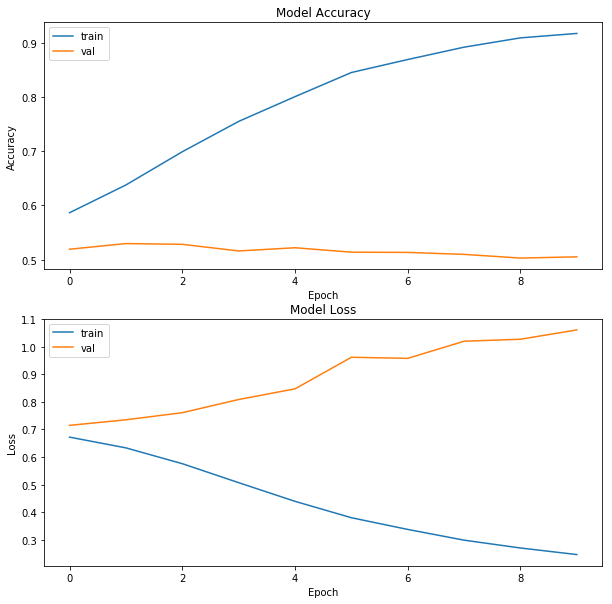

In [50]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [51]:
# Classification Report
y_true = np.argmax(test_targets, axis=1)
print(classification_report(y_true[:2208], predictions, target_names=labels))

              precision    recall  f1-score   support

Infiltration       0.51      0.89      0.65      1104
  No Finding       0.55      0.14      0.22      1104

   micro avg       0.51      0.51      0.51      2208
   macro avg       0.53      0.51      0.43      2208
weighted avg       0.53      0.51      0.43      2208



### Train Predictions

In [31]:
predictions = [np.argmax(ChestRESN50_model.predict(np.expand_dims(feature, axis=0))) for feature in train_DENSNET]

ValueError: Found input variables with inconsistent numbers of samples: [2000, 7260]

In [52]:
y_true = np.argmax(train_targets, axis=1)
print(classification_report(y_true[:2208], predictions, target_names=labels))

              precision    recall  f1-score   support

Infiltration       0.50      0.87      0.63      1109
  No Finding       0.47      0.12      0.19      1099

   micro avg       0.49      0.49      0.49      2208
   macro avg       0.48      0.49      0.41      2208
weighted avg       0.48      0.49      0.41      2208

